# Método de mínimos cuadrados

Recordemos que el valor neto de una neurona esta dado por

$$ neto_j = x_1 w_{j1} + x_2 w_{j2} + ... + x_n w_{jn} + \theta _j $$

vemos que esta fórmula se parece mucho a la de una regresión lineal. Por lo que podríamos aplicar esta técnica para encontrar los pesos óptimos.

A continuación vemos un ejemplo de cómo es esto posible


In [1]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [1]:
from sklearn.datasets import make_classification, make_regression
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm.keras import TqdmCallback

2023-09-10 08:56:39.872934: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 08:56:40.522777: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-10 08:56:40.526218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 08:56:43.792974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Generamos datos ficticios para entrenar un clasificador

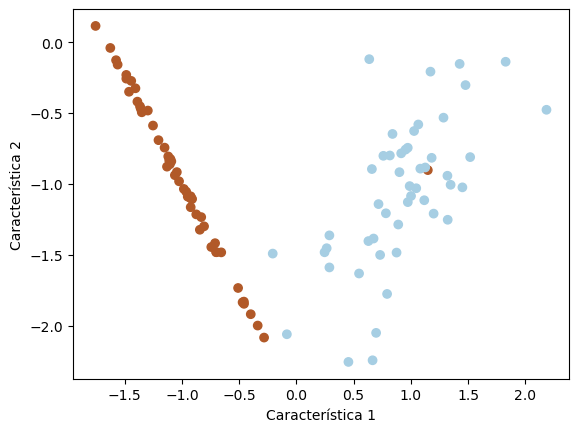

In [2]:
# Generar datos linealmente separables
X, y = make_classification(
    n_samples=100,   #100 datos
    n_features=2,    # 2 variables
    n_informative=2, # sin ruido
    n_redundant=0,   # sin dependencia?
    n_clusters_per_class=1
)

# Graficar los datos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()


In [3]:
X

array([[-0.94903796, -1.08940948],
       [ 0.69681415, -2.05048664],
       [-0.91162929, -1.10651454],
       [-1.36629719, -0.45232257],
       [-1.44290317, -0.2730254 ],
       [-0.28216957, -2.08366073],
       [ 1.14859662, -0.90226184],
       [ 1.28567753, -0.53240502],
       [-0.87473551, -1.21451539],
       [-0.92376739, -1.08696834],
       [-0.80665673, -1.29883625],
       [-0.33796242, -1.99888236],
       [ 0.87545844, -1.48406639],
       [-1.20471575, -0.69102534],
       [ 1.04738253, -1.0302294 ],
       [-0.83138953, -1.2337805 ],
       [ 1.00189601, -1.08490663],
       [ 1.17187024, -0.20767262],
       [ 0.91598123, -0.78388499],
       [ 0.26492338, -1.45326567],
       [ 1.51872878, -0.81059425],
       [ 0.7927557 , -1.77589283],
       [-1.10521088, -0.86081018],
       [ 0.71777689, -1.14205671],
       [-0.45742612, -1.84569253],
       [-0.65640332, -1.48257278],
       [ 1.02862748, -0.62649969],
       [-1.06156519, -0.93809961],
       [-1.35990051,

In [4]:
y

array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0])

A las variables independientes, agregamos una variable con 1s para que tenga en cuenta el bias.

In [5]:
X_bias = np.hstack((X, np.ones((X.shape[0], 1))))
X_bias   # x1, x2, teta

array([[-0.94903796, -1.08940948,  1.        ],
       [ 0.69681415, -2.05048664,  1.        ],
       [-0.91162929, -1.10651454,  1.        ],
       [-1.36629719, -0.45232257,  1.        ],
       [-1.44290317, -0.2730254 ,  1.        ],
       [-0.28216957, -2.08366073,  1.        ],
       [ 1.14859662, -0.90226184,  1.        ],
       [ 1.28567753, -0.53240502,  1.        ],
       [-0.87473551, -1.21451539,  1.        ],
       [-0.92376739, -1.08696834,  1.        ],
       [-0.80665673, -1.29883625,  1.        ],
       [-0.33796242, -1.99888236,  1.        ],
       [ 0.87545844, -1.48406639,  1.        ],
       [-1.20471575, -0.69102534,  1.        ],
       [ 1.04738253, -1.0302294 ,  1.        ],
       [-0.83138953, -1.2337805 ,  1.        ],
       [ 1.00189601, -1.08490663,  1.        ],
       [ 1.17187024, -0.20767262,  1.        ],
       [ 0.91598123, -0.78388499,  1.        ],
       [ 0.26492338, -1.45326567,  1.        ],
       [ 1.51872878, -0.81059425,  1.   

El generador entrega clasificaciones de 0 y 1. Convertimos el 0 en -1 para que la línea que cruce el 0

In [6]:
y[y==0] = -1
y

array([ 1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1, -1,  1, -1,
       -1, -1, -1, -1, -1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,
        1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1,
        1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,  1,
        1,  1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1,
        1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1,  1, -1, -1, -1])

**Ejercicio**

Calcula los pesos mediante mínimos cuadrados

In [7]:
w = np.linalg.lstsq(X_bias, y, rcond=None)[0]
w   # Peso1, peso2, bias

array([-0.8604954 , -0.04583526, -0.07151752])

Creamos la función de activación que será la de paso, nota que las salidas son -1 y 1 a diferencia de otros ejemplos

In [8]:
def step_function(x):
    return np.where(x >= 0, 1, -1)  # P1 (cero es nuestro punto de corte en la activación)

class Perceptron:
    def __init__(self, input_size):
        self.weights = np.random.rand(input_size)
        self.bias = np.random.rand()

    def predict(self, inputs):
        weighted_sum = np.dot(inputs, self.weights) + self.bias
        return step_function(weighted_sum)

    def train(self, X, y, epochs, learning_rate):
        for _ in range(epochs):
            for i in range(len(X)):
                prediction = self.predict(X[i])
                error = y[i] - prediction
                self.weights += learning_rate * error * X[i]
                self.bias += learning_rate * error

Con los pesos de mínimos cuadrados los asignamos al perceptrón

In [9]:
w[:2]

array([-0.8604954 , -0.04583526])

In [10]:
neurona = Perceptron(2)
neurona.weights = w[:2]
neurona.bias = w[-1]

Generamos una predicción con el perceptrón entrenado

In [11]:
y_pred = neurona.predict(X)

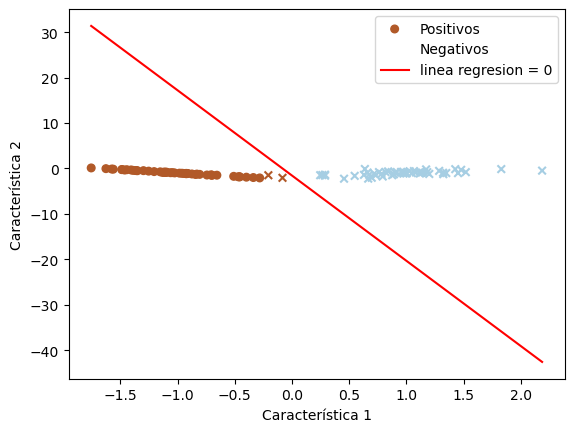

In [12]:
def line(x,w):
    # x1w1 + x2w2 + teta = 0  (este cero es importante por la función de activación ver P1)
    #x2 = (-teta - x1w1)/w2
    return -(w[0]*x + w[2]) / w[1]  
    # tomamos x2 porque es nuestra variable dependiente (y en el gráfico (que tan alto para x1))
    

x_range = np.linspace(min(X[:, 0]), max(X[:, 0]), 100)

y_line = [line(x,w) for x in x_range]

unos = 30*np.ones_like(y)
real_pos = np.ma.masked_where(y < 0, unos)
real_neg = np.ma.masked_where(y >= 0, unos)

plt.scatter(X[:, 0], X[:, 1], c=y_pred, marker="o", s=real_pos, cmap=plt.cm.Paired, label="Positivos")
plt.scatter(X[:, 0], X[:, 1], c=y_pred, marker="x", s=real_neg, cmap=plt.cm.Paired, label="Negativos")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.plot(x_range, y_line, color='red', label='linea regresion = 0')
plt.legend()
plt.show()

# nota intenta no quedar tan cerca de puntos para generalizar mejor

# Cosas que faltan
# normalizar
# no estamos separando en train y test


**Discusión**
Pudo predecir correctamente todos los casos ¿Por qué?      
La restricción de una regresión líneal, solo una neurona

# Descenso de gradiente

(Voz Queremos tener una serie de pesos tal que al sumar los pesos con las variables sea igual al valor esperado, formula elevamos al cuadrado para quitar negativos y para penalizar más entre más grande sea el error, n es el número de datos)

Recordemos que queremos hacer que $y_i = \hat{y}_i$ para todo i en los datos de entrenamiento.

Eso muchas veces es imposible, lo que podemos aspirar es minimizar la diferencia utilizando una función se le llama función de costo o de perdida, muchas veces denotada con $L$ o $C$. Un ejemplo de este tipo de funciones es el error cuadrado medio (MSE):

$$L(y, \hat{y}) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

No es la única pero resulta muy adecuada para los cálculos que veremos a continuación.  

Ahora, sabemos que la predicción o el paso hacia delante de la red/neurona viene dado por:

$$ \hat{y}_i = f(x_i \cdot w + b) $$

Donde:
- $x_i$ es el vector de características del ejemplo $i$,
- $w$ son los pesos,
- $b$ es el sesgo (bias),
- $f$ es la función de activación

por lo tanto, la función de costo queda

$$L(y, x_i , w , b) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - f(x_i \cdot w + b))^2 $$

si utilizamos la función de activación lineal tenemos que

$$L(y, x_i , w , b) = \frac{1}{2n} \sum_{i=1}^{n} (y_i - x_i \cdot w + b)^2 $$


Queremos minimizar esta función. Para ello podemos utilizar métodos como el descenso de gradiente. El cual viene dado por la regla de actualización

$$ w_{t+1} = w_{t} - \alpha \nabla_w L$$
$$ b_{t+1} = b_{t} - \alpha \nabla_b L$$

Donde:
- $w_{t+1}$ es el valor actualizado del peso.
- $w_{t}$ es el valor anterior del peso.
- $\alpha$ es la tasa de aprendizaje (gradiente (nos dice hacia donde sube más rápido la función), derivada respecto a cada una de las ___).
- $\nabla_w L$ es el gradiente de la función de pérdida con respecto al peso.
- $\nabla_b L$ es el gradiente de la función de pérdida con respecto al bias.

Calculando estos gradientes utilizando la regla de la cadena
$$ \nabla_w L= - \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) x_i $$

$$ \nabla_b L = - \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) $$

Entonces, tendremos que actualización de pesos y bias se puede calcular así

$$ w_{t+1} = w_{t} + \frac{\alpha}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) x_i $$
$$ b_{t+1} = b_{t} + \frac{\alpha}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) $$

en muchas ocasiones el error $e_i$ se define como $(y_i - \hat{y}_i)$

Tomando todo esto en consideración podemos implementar nuestro propio descenso de gradiente


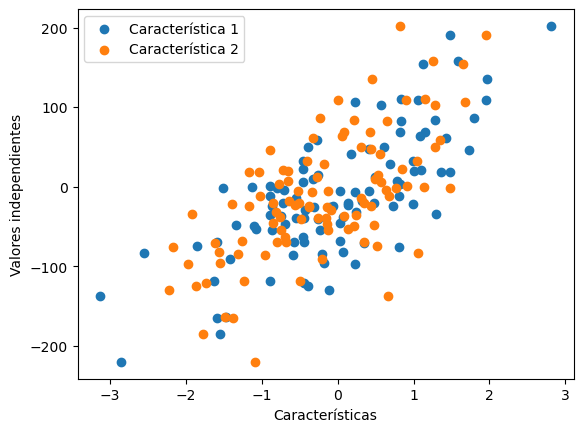

In [13]:
X, y = make_regression(n_samples=100, n_features=2, n_informative=2)

plt.scatter(X[:, 0], y, label="Característica 1")
plt.scatter(X[:, 1], y, label="Característica 2")
plt.xlabel("Características")
plt.ylabel("Valores independientes")
plt.legend()
plt.show()


In [14]:
len(X)

100

In [15]:
weights = np.random.randn(2)  # Pesos iniciales
bias = np.random.randn()

# Parámetros de entrenamiento
learning_rate = 0.1
epochs = 100

# Función de activación
def activation(x):
  return x  # Lineal


In [16]:
# Entrenamiento mediante descenso de gradiente
for epoch in range(epochs):
    total_error = 0
    grad_weights = np.zeros(2)
    grad_bias = 0
    n = len(X)

    for i in range(n):
        activation_input = np.dot(X[i], weights) + bias
        y_pred = activation(activation_input)

        error = y[i] - y_pred
        total_error += error**2

        grad_weights += error * X[i] # ver formula arriba (w_t +1)
        grad_bias += error   # ver formula arriba (b_t + 1)

    # Actualización de pesos y sesgo después de un lote de ejemplos
    weights += learning_rate * grad_weights / n
    bias += learning_rate * grad_bias / n

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Error: {total_error}")

print("Pesos finales:", weights)
print("Sesgo final:", bias)


Epoch 0, Error: 589905.1265946872
Epoch 10, Error: 71406.46554685524
Epoch 20, Error: 10260.212374196066
Epoch 30, Error: 1707.8687611761072
Epoch 40, Error: 312.7446592313663
Epoch 50, Error: 60.26486213428898
Epoch 60, Error: 11.89952288285336
Epoch 70, Error: 2.3756965119450286
Epoch 80, Error: 0.47661775623775243
Epoch 90, Error: 0.09582404304744348
Pesos finales: [55.74876876 55.46295698]
Sesgo final: -0.010099457439425339


Otro tipo de activaciones funcionan de manera muy parecida como es **Rectified Linear Unit** mayormente referida como **ReLU** la cual está definida como

$$f(x) = max(0,x)$$

y resulta en un gradiente muy parecido al de la activación lineal.





## Clasificación

**Discusión**

¿Como sería el descenso de gradiente para la función de paso binario?


Para hacer clasificación podemos usar otras funciones de activación como es la sigmoidal.

Vamos a ver un ejemplo de cómo podemos utilizar esta función para problemas de clasificación.

Comenzamos generando una serie de datos para clasificar

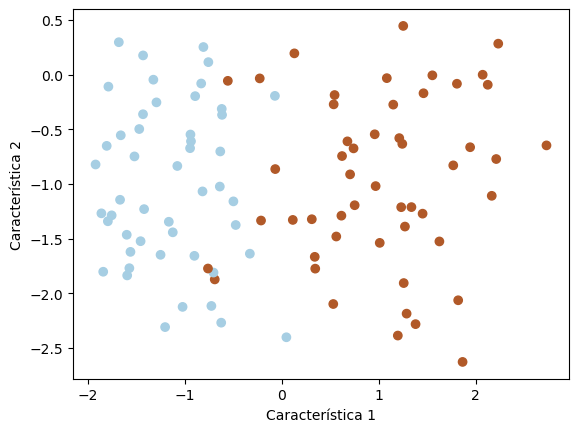

In [17]:
# Generar datos
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

# Graficar los datos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

Definimos la función de activación y su derivada así como los pesos iniciales y parámetros de entrenamiento.

In [18]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))   #source confianza en prof (derivar e^-x)

In [19]:
weights = np.random.randn(2)
bias = np.random.randn()

# Parámetros de entrenamiento
learning_rate = 0.1
#epochs = 10000
epochs = 10

In [25]:
for i in range(len(X)):
    print(X[i])

[ 1.81887659 -2.06356395]
[-1.41853339 -1.23016754]
[-1.79208941 -1.34107918]
[-1.84006629 -1.80276444]
[-1.55926515 -1.62104961]
[ 0.53123898 -2.09784522]
[-1.78662353 -0.11014125]
[ 0.61514358 -1.29005912]
[-1.42913017  0.17522198]
[-0.69034076 -1.87292321]
[ 1.80608889 -0.08384892]
[ 1.21165877 -0.58091929]
[-1.12302178 -1.44223871]
[ 1.1967126  -2.38618887]
[-1.75303266 -1.2870741 ]
[ 0.74040392 -0.67474692]
[ 0.95860508 -0.54596211]
[-0.70319474 -1.8102482 ]
[-0.07012035 -0.19460891]
[ 0.34540522 -1.77440923]
[ 0.70472267 -0.91239753]
[-0.6381669  -1.02394348]
[-0.81643706 -1.06822387]
[-1.46864237 -0.49785129]
[ 0.53556647 -0.27232571]
[-1.20213999 -2.30878652]
[ 1.33690475 -1.21173759]
[ 0.54497344 -0.18704026]
[ 0.67722377 -0.61054186]
[ 1.01034345 -1.53874528]
[ 1.45207949 -1.27170717]
[ 1.9420347  -0.66415458]
[-0.8072552   0.25191268]
[-0.22662318 -0.03493047]
[2.23181986 0.28265437]
[ 0.62166803 -0.74489508]
[-1.85883757 -1.26868045]
[ 2.07126774e+00 -1.37794480e-03]
[-1.80

In [21]:
for epoch in range(epochs):
    total_error = 0
    gradient_weights = 0
    gradient_bias = 0
    n = len(X)

    for i in range(n):
        # calc neurona
        z = np.dot(X[i], weights) + bias
        y_pred = sigmoid(z)

        # calc error
        error = y[i] - y_pred
        total_error += error**2

        # formula L(y,x, w, b) = 1/2n Sum(y1-f(x1 * w + b))^2
        # al derivar sobre f(w) es -2 * error
        d_cost_d_output = -2 * error
        d_output_d_input = sigmoid_derivative(y_pred)

        gradient_weights += d_cost_d_output * d_output_d_input * X[i]
        #gradient_weights -= error  * d_output_d_input * X[i]
        gradient_bias += d_cost_d_output * d_output_d_input

    # Actualización de pesos y sesgo
    print("PRE")
    print( gradient_weights)
    
    weights -= learning_rate * gradient_weights / n
    print("POST")
    print(weights)
    bias -= learning_rate * gradient_bias / n

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Error: {total_error.mean()}")



PRE
[-0.0269522  -0.00783347]
POST
[4.6149656 0.1336352]
Epoch 0, Error: 4.38048255965834
PRE
[-0.02694549 -0.00783139]
POST
[4.61499255 0.13364303]
PRE
[-0.02693879 -0.0078293 ]
POST
[4.61501949 0.13365086]
PRE
[-0.02693209 -0.00782722]
POST
[4.61504642 0.13365868]
PRE
[-0.02692539 -0.00782514]
POST
[4.61507334 0.13366651]
PRE
[-0.02691869 -0.00782306]
POST
[4.61510026 0.13367433]
PRE
[-0.026912   -0.00782098]
POST
[4.61512717 0.13368215]
PRE
[-0.0269053  -0.00781891]
POST
[4.61515408 0.13368997]
PRE
[-0.02689861 -0.00781683]
POST
[4.61518098 0.13369779]
PRE
[-0.02689192 -0.00781475]
POST
[4.61520787 0.1337056 ]
PRE
[-0.02688523 -0.00781267]
POST
[4.61523475 0.13371342]
PRE
[-0.02687855 -0.0078106 ]
POST
[4.61526163 0.13372123]
PRE
[-0.02687186 -0.00780852]
POST
[4.61528851 0.13372903]
PRE
[-0.02686518 -0.00780645]
POST
[4.61531537 0.13373684]
PRE
[-0.0268585  -0.00780437]
POST
[4.61534223 0.13374465]
PRE
[-0.02685182 -0.0078023 ]
POST
[4.61536908 0.13375245]
PRE
[-0.02684514 -0.00780

PRE
[-0.02567794 -0.00743864]
POST
[4.62009533 0.13512367]
PRE
[-0.02567157 -0.00743667]
POST
[4.620121  0.1351311]
PRE
[-0.02566521 -0.0074347 ]
POST
[4.62014667 0.13513854]
PRE
[-0.02565885 -0.00743274]
POST
[4.62017233 0.13514597]
PRE
[-0.02565248 -0.00743077]
POST
[4.62019798 0.1351534 ]
PRE
[-0.02564613 -0.0074288 ]
POST
[4.62022363 0.13516083]
Epoch 200, Error: 4.38040769220724
PRE
[-0.02563977 -0.00742684]
POST
[4.62024927 0.13516826]
PRE
[-0.02563341 -0.00742487]
POST
[4.6202749  0.13517568]
PRE
[-0.02562706 -0.00742291]
POST
[4.62030053 0.13518311]
PRE
[-0.0256207  -0.00742095]
POST
[4.62032615 0.13519053]
PRE
[-0.02561435 -0.00741898]
POST
[4.62035176 0.13519795]
PRE
[-0.025608   -0.00741702]
POST
[4.62037737 0.13520536]
PRE
[-0.02560165 -0.00741506]
POST
[4.62040297 0.13521278]
PRE
[-0.02559531 -0.0074131 ]
POST
[4.62042857 0.13522019]
PRE
[-0.02558896 -0.00741114]
POST
[4.62045416 0.1352276 ]
PRE
[-0.02558262 -0.00740918]
POST
[4.62047974 0.13523501]
PRE
[-0.02557628 -0.007

PRE
[-0.02442541 -0.00705236]
POST
[4.62515402 0.13658669]
PRE
[-0.02441937 -0.0070505 ]
POST
[4.62517844 0.13659374]
PRE
[-0.02441333 -0.00704865]
POST
[4.62520285 0.13660079]
PRE
[-0.0244073  -0.00704679]
POST
[4.62522726 0.13660783]
Epoch 400, Error: 4.380341789351781
PRE
[-0.02440127 -0.00704494]
POST
[4.62525166 0.13661488]
PRE
[-0.02439524 -0.00704308]
POST
[4.62527606 0.13662192]
PRE
[-0.02438921 -0.00704123]
POST
[4.62530045 0.13662896]
PRE
[-0.02438318 -0.00703937]
POST
[4.62532483 0.136636  ]
PRE
[-0.02437716 -0.00703752]
POST
[4.62534921 0.13664304]
PRE
[-0.02437113 -0.00703567]
POST
[4.62537358 0.13665008]
PRE
[-0.02436511 -0.00703381]
POST
[4.62539794 0.13665711]
PRE
[-0.02435909 -0.00703196]
POST
[4.6254223  0.13666414]
PRE
[-0.02435307 -0.00703011]
POST
[4.62544666 0.13667117]
PRE
[-0.02434705 -0.00702826]
POST
[4.625471  0.1366782]
PRE
[-0.02434104 -0.00702641]
POST
[4.62549534 0.13668523]
PRE
[-0.02433502 -0.00702456]
POST
[4.62551968 0.13669225]
PRE
[-0.02432901 -0.00

PRE
[-0.02315756 -0.00666328]
POST
[4.63029106 0.13806735]
PRE
[-0.02315185 -0.00666154]
POST
[4.63031421 0.13807401]
PRE
[-0.02314615 -0.00665979]
POST
[4.63033736 0.13808067]
PRE
[-0.02314045 -0.00665805]
POST
[4.6303605  0.13808733]
PRE
[-0.02313475 -0.0066563 ]
POST
[4.63038363 0.13809399]
PRE
[-0.02312905 -0.00665456]
POST
[4.63040676 0.13810064]
PRE
[-0.02312335 -0.00665281]
POST
[4.63042988 0.13810729]
PRE
[-0.02311765 -0.00665107]
POST
[4.630453   0.13811395]
PRE
[-0.02311196 -0.00664933]
POST
[4.63047611 0.1381206 ]
PRE
[-0.02310627 -0.00664759]
POST
[4.63049922 0.13812724]
PRE
[-0.02310057 -0.00664584]
POST
[4.63052232 0.13813389]
PRE
[-0.02309488 -0.0066441 ]
POST
[4.63054541 0.13814053]
PRE
[-0.0230892  -0.00664236]
POST
[4.6305685  0.13814718]
PRE
[-0.02308351 -0.00664062]
POST
[4.63059159 0.13815382]
PRE
[-0.02307782 -0.00663888]
POST
[4.63061466 0.13816045]
PRE
[-0.02307214 -0.00663714]
POST
[4.63063774 0.13816709]
PRE
[-0.02306646 -0.0066354 ]
POST
[4.6306608  0.1381737

PRE
[-0.02219785 -0.00637011]
POST
[4.63419053 0.13918787]
PRE
[-0.0221924  -0.00636845]
POST
[4.63421272 0.13919424]
PRE
[-0.02218695 -0.00636678]
POST
[4.63423491 0.13920061]
PRE
[-0.02218149 -0.00636512]
POST
[4.63425709 0.13920697]
PRE
[-0.02217604 -0.00636346]
POST
[4.63427926 0.13921334]
PRE
[-0.02217059 -0.0063618 ]
POST
[4.63430143 0.1392197 ]
PRE
[-0.02216514 -0.00636014]
POST
[4.6343236  0.13922606]
PRE
[-0.0221597  -0.00635848]
POST
[4.63434576 0.13923242]
PRE
[-0.02215425 -0.00635682]
POST
[4.63436791 0.13923877]
PRE
[-0.02214881 -0.00635516]
POST
[4.63439006 0.13924513]
PRE
[-0.02214337 -0.0063535 ]
POST
[4.63441221 0.13925148]
PRE
[-0.02213793 -0.00635184]
POST
[4.63443434 0.13925783]
PRE
[-0.02213249 -0.00635018]
POST
[4.63445648 0.13926418]
PRE
[-0.02212705 -0.00634853]
POST
[4.6344786  0.13927053]
PRE
[-0.02212161 -0.00634687]
POST
[4.63450073 0.13927688]
PRE
[-0.02211618 -0.00634521]
POST
[4.63452284 0.13928322]
Epoch 800, Error: 4.380233189125106
PRE
[-0.02211074 -0.

PRE
[-0.02135324 -0.00611308]
POST
[4.63763019 0.14017376]
PRE
[-0.021348   -0.00611149]
POST
[4.63765153 0.14017988]
PRE
[-0.02134277 -0.0061099 ]
POST
[4.63767288 0.14018599]
PRE
[-0.02133753 -0.00610831]
POST
[4.63769421 0.14019209]
PRE
[-0.0213323  -0.00610672]
POST
[4.63771555 0.1401982 ]
PRE
[-0.02132707 -0.00610513]
POST
[4.63773687 0.14020431]
PRE
[-0.02132184 -0.00610354]
POST
[4.6377582  0.14021041]
PRE
[-0.02131661 -0.00610195]
POST
[4.63777951 0.14021651]
PRE
[-0.02131138 -0.00610037]
POST
[4.63780082 0.14022261]
PRE
[-0.02130616 -0.00609878]
POST
[4.63782213 0.14022871]
PRE
[-0.02130093 -0.00609719]
POST
[4.63784343 0.14023481]
PRE
[-0.02129571 -0.00609561]
POST
[4.63786473 0.1402409 ]
PRE
[-0.02129049 -0.00609402]
POST
[4.63788602 0.140247  ]
PRE
[-0.02128527 -0.00609244]
POST
[4.6379073  0.14025309]
PRE
[-0.02128005 -0.00609085]
POST
[4.63792858 0.14025918]
PRE
[-0.02127483 -0.00608927]
POST
[4.63794986 0.14026527]
PRE
[-0.02126962 -0.00608768]
POST
[4.63797113 0.1402713

PRE
[-0.0205575  -0.00587179]
POST
[4.64087746 0.14110234]
PRE
[-0.02055246 -0.00587027]
POST
[4.64089801 0.14110821]
PRE
[-0.02054743 -0.00586875]
POST
[4.64091856 0.14111407]
Epoch 1100, Error: 4.3801689120870035
PRE
[-0.02054241 -0.00586722]
POST
[4.6409391  0.14111994]
PRE
[-0.02053738 -0.0058657 ]
POST
[4.64095964 0.14112581]
PRE
[-0.02053235 -0.00586418]
POST
[4.64098017 0.14113167]
PRE
[-0.02052733 -0.00586266]
POST
[4.6410007  0.14113753]
PRE
[-0.0205223  -0.00586114]
POST
[4.64102122 0.1411434 ]
PRE
[-0.02051728 -0.00585962]
POST
[4.64104174 0.14114926]
PRE
[-0.02051226 -0.0058581 ]
POST
[4.64106225 0.14115511]
PRE
[-0.02050724 -0.00585658]
POST
[4.64108276 0.14116097]
PRE
[-0.02050222 -0.00585506]
POST
[4.64110326 0.14116683]
PRE
[-0.02049721 -0.00585354]
POST
[4.64112376 0.14117268]
PRE
[-0.02049219 -0.00585203]
POST
[4.64114425 0.14117853]
PRE
[-0.02048717 -0.00585051]
POST
[4.64116474 0.14118438]
PRE
[-0.02048216 -0.00584899]
POST
[4.64118522 0.14119023]
PRE
[-0.02047715 -

PRE
[-0.0197687  -0.00563346]
POST
[4.64410273 0.1420225 ]
PRE
[-0.01976388 -0.00563201]
POST
[4.64412249 0.14202813]
PRE
[-0.01975905 -0.00563055]
POST
[4.64414225 0.14203376]
PRE
[-0.01975422 -0.0056291 ]
POST
[4.64416201 0.14203939]
PRE
[-0.0197494  -0.00562764]
POST
[4.64418176 0.14204501]
PRE
[-0.01974457 -0.00562619]
POST
[4.6442015  0.14205064]
PRE
[-0.01973975 -0.00562473]
POST
[4.64422124 0.14205627]
PRE
[-0.01973493 -0.00562328]
POST
[4.64424097 0.14206189]
PRE
[-0.01973011 -0.00562183]
POST
[4.6442607  0.14206751]
PRE
[-0.01972529 -0.00562037]
POST
[4.64428043 0.14207313]
PRE
[-0.01972047 -0.00561892]
POST
[4.64430015 0.14207875]
PRE
[-0.01971565 -0.00561747]
POST
[4.64431987 0.14208437]
PRE
[-0.01971084 -0.00561602]
POST
[4.64433958 0.14208998]
PRE
[-0.01970603 -0.00561456]
POST
[4.64435928 0.1420956 ]
PRE
[-0.01970121 -0.00561311]
POST
[4.64437898 0.14210121]
PRE
[-0.0196964  -0.00561166]
POST
[4.64439868 0.14210682]
PRE
[-0.01969159 -0.00561021]
POST
[4.64441837 0.1421124

PRE
[-0.01881335 -0.00534598]
POST
[4.64801749 0.14313649]
PRE
[-0.01880877 -0.00534461]
POST
[4.6480363  0.14314184]
PRE
[-0.01880418 -0.00534323]
POST
[4.6480551  0.14314718]
PRE
[-0.0187996  -0.00534185]
POST
[4.6480739  0.14315252]
PRE
[-0.01879502 -0.00534048]
POST
[4.6480927  0.14315786]
PRE
[-0.01879044 -0.0053391 ]
POST
[4.64811149 0.1431632 ]
PRE
[-0.01878586 -0.00533773]
POST
[4.64813028 0.14316854]
PRE
[-0.01878128 -0.00533635]
POST
[4.64814906 0.14317387]
PRE
[-0.01877671 -0.00533498]
POST
[4.64816783 0.14317921]
PRE
[-0.01877213 -0.00533361]
POST
[4.64818661 0.14318454]
PRE
[-0.01876756 -0.00533223]
POST
[4.64820537 0.14318988]
PRE
[-0.01876298 -0.00533086]
POST
[4.64822414 0.14319521]
PRE
[-0.01875841 -0.00532949]
POST
[4.64824289 0.14320054]
PRE
[-0.01875384 -0.00532812]
POST
[4.64826165 0.14320586]
PRE
[-0.01874927 -0.00532675]
POST
[4.6482804  0.14321119]
PRE
[-0.0187447  -0.00532538]
POST
[4.64829914 0.14321652]
PRE
[-0.01874014 -0.005324  ]
POST
[4.64831788 0.1432218

PRE
[-0.01818716 -0.00515826]
POST
[4.65058846 0.14386636]
Epoch 1600, Error: 4.3800878970591395
PRE
[-0.01818273 -0.00515694]
POST
[4.65060664 0.14387152]
PRE
[-0.01817831 -0.00515561]
POST
[4.65062482 0.14387667]
PRE
[-0.01817388 -0.00515429]
POST
[4.65064299 0.14388183]
PRE
[-0.01816946 -0.00515296]
POST
[4.65066116 0.14388698]
PRE
[-0.01816504 -0.00515164]
POST
[4.65067933 0.14389213]
PRE
[-0.01816062 -0.00515032]
POST
[4.65069749 0.14389728]
PRE
[-0.0181562 -0.005149 ]
POST
[4.65071564 0.14390243]
PRE
[-0.01815179 -0.00514767]
POST
[4.65073379 0.14390758]
PRE
[-0.01814737 -0.00514635]
POST
[4.65075194 0.14391272]
PRE
[-0.01814295 -0.00514503]
POST
[4.65077009 0.14391787]
PRE
[-0.01813854 -0.00514371]
POST
[4.65078822 0.14392301]
PRE
[-0.01813413 -0.00514239]
POST
[4.65080636 0.14392815]
PRE
[-0.01812972 -0.00514107]
POST
[4.65082449 0.1439333 ]
PRE
[-0.0181253  -0.00513975]
POST
[4.65084261 0.14393844]
PRE
[-0.0181209  -0.00513843]
POST
[4.65086073 0.14394357]
PRE
[-0.01811649 -0.

PRE
[-0.01735778 -0.00491052]
POST
[4.65399971 0.14483263]
PRE
[-0.01735356 -0.00490926]
POST
[4.65401706 0.14483754]
PRE
[-0.01734935 -0.004908  ]
POST
[4.65403441 0.14484245]
PRE
[-0.01734514 -0.00490675]
POST
[4.65405176 0.14484735]
PRE
[-0.01734092 -0.00490549]
POST
[4.6540691  0.14485226]
PRE
[-0.01733671 -0.00490424]
POST
[4.65408643 0.14485716]
PRE
[-0.0173325  -0.00490298]
POST
[4.65410377 0.14486206]
PRE
[-0.0173283  -0.00490173]
POST
[4.6541211  0.14486697]
PRE
[-0.01732409 -0.00490047]
POST
[4.65413842 0.14487187]
Epoch 1800, Error: 4.380063038889719
PRE
[-0.01731988 -0.00489922]
POST
[4.65415574 0.14487677]
PRE
[-0.01731568 -0.00489797]
POST
[4.65417306 0.14488166]
PRE
[-0.01731147 -0.00489671]
POST
[4.65419037 0.14488656]
PRE
[-0.01730727 -0.00489546]
POST
[4.65420767 0.14489146]
PRE
[-0.01730307 -0.00489421]
POST
[4.65422498 0.14489635]
PRE
[-0.01729887 -0.00489296]
POST
[4.65424228 0.14490124]
PRE
[-0.01729467 -0.00489171]
POST
[4.65425957 0.14490613]
PRE
[-0.01729047 -0

PRE
[-0.01678608 -0.00474035]
POST
[4.65635512 0.14549838]
PRE
[-0.01678201 -0.00473914]
POST
[4.6563719  0.14550312]
PRE
[-0.01677794 -0.00473793]
POST
[4.65638868 0.14550786]
PRE
[-0.01677387 -0.00473672]
POST
[4.65640545 0.14551259]
PRE
[-0.01676981 -0.00473551]
POST
[4.65642222 0.14551733]
PRE
[-0.01676574 -0.0047343 ]
POST
[4.65643899 0.14552206]
PRE
[-0.01676168 -0.00473309]
POST
[4.65645575 0.14552679]
PRE
[-0.01675761 -0.00473188]
POST
[4.65647251 0.14553153]
PRE
[-0.01675355 -0.00473068]
POST
[4.65648926 0.14553626]
PRE
[-0.01674949 -0.00472947]
POST
[4.65650601 0.14554099]
PRE
[-0.01674542 -0.00472826]
POST
[4.65652276 0.14554572]
PRE
[-0.01674136 -0.00472706]
POST
[4.6565395  0.14555044]
PRE
[-0.01673731 -0.00472585]
POST
[4.65655624 0.14555517]
PRE
[-0.01673325 -0.00472464]
POST
[4.65657297 0.14555989]
PRE
[-0.01672919 -0.00472344]
POST
[4.6565897  0.14556462]
PRE
[-0.01672513 -0.00472223]
POST
[4.65660642 0.14556934]
PRE
[-0.01672108 -0.00472103]
POST
[4.65662314 0.1455740

PRE
[-0.0160192  -0.00451286]
POST
[4.65951985 0.14639101]
PRE
[-0.01601532 -0.00451171]
POST
[4.65953586 0.14639552]
PRE
[-0.01601145 -0.00451057]
POST
[4.65955187 0.14640003]
PRE
[-0.01600757 -0.00450942]
POST
[4.65956788 0.14640454]
PRE
[-0.0160037  -0.00450827]
POST
[4.65958389 0.14640905]
PRE
[-0.01599982 -0.00450713]
POST
[4.65959989 0.14641355]
PRE
[-0.01599595 -0.00450598]
POST
[4.65961588 0.14641806]
PRE
[-0.01599208 -0.00450483]
POST
[4.65963187 0.14642256]
PRE
[-0.01598821 -0.00450369]
POST
[4.65964786 0.14642707]
PRE
[-0.01598434 -0.00450254]
POST
[4.65966385 0.14643157]
PRE
[-0.01598047 -0.0045014 ]
POST
[4.65967983 0.14643607]
PRE
[-0.0159766  -0.00450025]
POST
[4.6596958  0.14644057]
PRE
[-0.01597274 -0.00449911]
POST
[4.65971178 0.14644507]
PRE
[-0.01596887 -0.00449796]
POST
[4.65972774 0.14644957]
PRE
[-0.01596501 -0.00449682]
POST
[4.65974371 0.14645407]
PRE
[-0.01596114 -0.00449568]
POST
[4.65975967 0.14645856]
PRE
[-0.01595728 -0.00449453]
POST
[4.65977563 0.1464630

PRE
[-0.01524806 -0.00428504]
POST
[4.66270805 0.14728806]
PRE
[-0.01524438 -0.00428396]
POST
[4.6627233  0.14729235]
PRE
[-0.0152407  -0.00428287]
POST
[4.66273854 0.14729663]
PRE
[-0.01523701 -0.00428178]
POST
[4.66275377 0.14730091]
PRE
[-0.01523333 -0.0042807 ]
POST
[4.66276901 0.14730519]
PRE
[-0.01522965 -0.00427961]
POST
[4.66278424 0.14730947]
PRE
[-0.01522597 -0.00427853]
POST
[4.66279946 0.14731375]
PRE
[-0.0152223  -0.00427745]
POST
[4.66281468 0.14731803]
PRE
[-0.01521862 -0.00427636]
POST
[4.6628299  0.14732231]
PRE
[-0.01521494 -0.00427528]
POST
[4.66284512 0.14732658]
PRE
[-0.01521127 -0.00427419]
POST
[4.66286033 0.14733086]
PRE
[-0.01520759 -0.00427311]
POST
[4.66287554 0.14733513]
PRE
[-0.01520392 -0.00427203]
POST
[4.66289074 0.1473394 ]
PRE
[-0.01520025 -0.00427095]
POST
[4.66290594 0.14734367]
PRE
[-0.01519657 -0.00426986]
POST
[4.66292114 0.14734794]
PRE
[-0.0151929  -0.00426878]
POST
[4.66293633 0.14735221]
PRE
[-0.01518923 -0.0042677 ]
POST
[4.66295152 0.1473564

PRE
[-0.01454337 -0.00407768]
POST
[4.6656267  0.14810733]
PRE
[-0.01453987 -0.00407665]
POST
[4.66564124 0.14811141]
PRE
[-0.01453636 -0.00407562]
POST
[4.66565577 0.14811548]
PRE
[-0.01453285 -0.00407459]
POST
[4.6656703  0.14811956]
PRE
[-0.01452935 -0.00407356]
POST
[4.66568483 0.14812363]
PRE
[-0.01452584 -0.00407253]
POST
[4.66569936 0.1481277 ]
PRE
[-0.01452234 -0.0040715 ]
POST
[4.66571388 0.14813177]
PRE
[-0.01451884 -0.00407048]
POST
[4.6657284  0.14813584]
PRE
[-0.01451534 -0.00406945]
POST
[4.66574292 0.14813991]
PRE
[-0.01451184 -0.00406842]
POST
[4.66575743 0.14814398]
PRE
[-0.01450834 -0.00406739]
POST
[4.66577194 0.14814805]
PRE
[-0.01450484 -0.00406637]
POST
[4.66578644 0.14815212]
PRE
[-0.01450134 -0.00406534]
POST
[4.66580094 0.14815618]
PRE
[-0.01449784 -0.00406431]
POST
[4.66581544 0.14816024]
PRE
[-0.01449435 -0.00406328]
POST
[4.66582994 0.14816431]
PRE
[-0.01449085 -0.00406226]
POST
[4.66584443 0.14816837]
PRE
[-0.01448736 -0.00406123]
POST
[4.66585891 0.1481724

PRE
[-0.01406411 -0.00393712]
POST
[4.66761448 0.14866423]
PRE
[-0.01406072 -0.00393612]
POST
[4.66762854 0.14866816]
PRE
[-0.01405734 -0.00393513]
POST
[4.6676426 0.1486721]
PRE
[-0.01405395 -0.00393414]
POST
[4.66765666 0.14867603]
PRE
[-0.01405056 -0.00393315]
POST
[4.66767071 0.14867996]
PRE
[-0.01404718 -0.00393216]
POST
[4.66768475 0.1486839 ]
PRE
[-0.0140438  -0.00393116]
POST
[4.6676988  0.14868783]
PRE
[-0.01404041 -0.00393017]
POST
[4.66771284 0.14869176]
PRE
[-0.01403703 -0.00392918]
POST
[4.66772687 0.14869569]
PRE
[-0.01403365 -0.00392819]
POST
[4.66774091 0.14869962]
PRE
[-0.01403027 -0.0039272 ]
POST
[4.66775494 0.14870354]
PRE
[-0.01402689 -0.00392621]
POST
[4.66776897 0.14870747]
PRE
[-0.01402351 -0.00392522]
POST
[4.66778299 0.14871139]
PRE
[-0.01402013 -0.00392423]
POST
[4.66779701 0.14871532]
PRE
[-0.01401675 -0.00392325]
POST
[4.66781103 0.14871924]
PRE
[-0.01401338 -0.00392226]
POST
[4.66782504 0.14872316]
PRE
[-0.01401    -0.00392127]
POST
[4.66783905 0.14872709]

PRE
[-0.01358807 -0.00379787]
POST
[4.66959117 0.14921714]
PRE
[-0.0135848  -0.00379691]
POST
[4.66960476 0.14922094]
PRE
[-0.01358153 -0.00379596]
POST
[4.66961834 0.14922474]
PRE
[-0.01357826 -0.003795  ]
POST
[4.66963192 0.14922853]
PRE
[-0.01357499 -0.00379405]
POST
[4.66964549 0.14923233]
PRE
[-0.01357173 -0.00379309]
POST
[4.66965907 0.14923612]
PRE
[-0.01356846 -0.00379214]
POST
[4.66967263 0.14923991]
PRE
[-0.0135652  -0.00379119]
POST
[4.6696862 0.1492437]
PRE
[-0.01356193 -0.00379023]
POST
[4.66969976 0.14924749]
PRE
[-0.01355867 -0.00378928]
POST
[4.66971332 0.14925128]
PRE
[-0.01355541 -0.00378833]
POST
[4.66972688 0.14925507]
PRE
[-0.01355214 -0.00378737]
POST
[4.66974043 0.14925886]
PRE
[-0.01354888 -0.00378642]
POST
[4.66975398 0.14926264]
PRE
[-0.01354562 -0.00378547]
POST
[4.66976752 0.14926643]
PRE
[-0.01354236 -0.00378452]
POST
[4.66978106 0.14927021]
PRE
[-0.01353911 -0.00378357]
POST
[4.6697946 0.149274 ]
PRE
[-0.01353585 -0.00378261]
POST
[4.66980814 0.14927778]
P

PRE
[-0.01289411 -0.00359555]
POST
[4.6724767  0.15002271]
PRE
[-0.01289101 -0.00359465]
POST
[4.67248959 0.15002631]
PRE
[-0.01288792 -0.00359375]
POST
[4.67250248 0.1500299 ]
PRE
[-0.01288482 -0.00359285]
POST
[4.67251537 0.15003349]
PRE
[-0.01288172 -0.00359195]
POST
[4.67252825 0.15003709]
PRE
[-0.01287863 -0.00359105]
POST
[4.67254113 0.15004068]
PRE
[-0.01287554 -0.00359015]
POST
[4.672554   0.15004427]
PRE
[-0.01287244 -0.00358925]
POST
[4.67256688 0.15004786]
PRE
[-0.01286935 -0.00358835]
POST
[4.67257975 0.15005144]
PRE
[-0.01286626 -0.00358745]
POST
[4.67259261 0.15005503]
PRE
[-0.01286317 -0.00358655]
POST
[4.67260547 0.15005862]
PRE
[-0.01286008 -0.00358565]
POST
[4.67261833 0.1500622 ]
PRE
[-0.01285699 -0.00358475]
POST
[4.67263119 0.15006579]
PRE
[-0.0128539  -0.00358386]
POST
[4.67264405 0.15006937]
PRE
[-0.01285081 -0.00358296]
POST
[4.6726569  0.15007296]
PRE
[-0.01284773 -0.00358206]
POST
[4.67266974 0.15007654]
PRE
[-0.01284464 -0.00358116]
POST
[4.67268259 0.1500801

PRE
[-0.01227484 -0.0034157 ]
POST
[4.67505568 0.15074111]
PRE
[-0.0122719  -0.00341485]
POST
[4.67506795 0.15074452]
PRE
[-0.01226895 -0.003414  ]
POST
[4.67508022 0.15074794]
PRE
[-0.01226601 -0.00341314]
POST
[4.67509248 0.15075135]
PRE
[-0.01226307 -0.00341229]
POST
[4.67510475 0.15075476]
PRE
[-0.01226013 -0.00341144]
POST
[4.67511701 0.15075818]
PRE
[-0.01225718 -0.00341059]
POST
[4.67512926 0.15076159]
PRE
[-0.01225424 -0.00340973]
POST
[4.67514152 0.150765  ]
PRE
[-0.0122513  -0.00340888]
POST
[4.67515377 0.1507684 ]
PRE
[-0.01224837 -0.00340803]
POST
[4.67516602 0.15077181]
PRE
[-0.01224543 -0.00340718]
POST
[4.67517826 0.15077522]
PRE
[-0.01224249 -0.00340633]
POST
[4.6751905  0.15077863]
PRE
[-0.01223955 -0.00340548]
POST
[4.67520274 0.15078203]
PRE
[-0.01223662 -0.00340463]
POST
[4.67521498 0.15078544]
PRE
[-0.01223368 -0.00340377]
POST
[4.67522721 0.15078884]
PRE
[-0.01223075 -0.00340292]
POST
[4.67523945 0.15079224]
PRE
[-0.01222781 -0.00340207]
POST
[4.67525167 0.1507956

PRE
[-0.01174508 -0.00326237]
POST
[4.67726487 0.1513553 ]
PRE
[-0.01174226 -0.00326156]
POST
[4.67727662 0.15135856]
PRE
[-0.01173945 -0.00326075]
POST
[4.67728836 0.15136182]
PRE
[-0.01173664 -0.00325993]
POST
[4.67730009 0.15136508]
PRE
[-0.01173383 -0.00325912]
POST
[4.67731183 0.15136834]
PRE
[-0.01173101 -0.00325831]
POST
[4.67732356 0.1513716 ]
PRE
[-0.0117282 -0.0032575]
POST
[4.67733529 0.15137486]
PRE
[-0.01172539 -0.00325669]
POST
[4.67734701 0.15137812]
PRE
[-0.01172258 -0.00325587]
POST
[4.67735873 0.15138137]
PRE
[-0.01171978 -0.00325506]
POST
[4.67737045 0.15138463]
PRE
[-0.01171697 -0.00325425]
POST
[4.67738217 0.15138788]
PRE
[-0.01171416 -0.00325344]
POST
[4.67739388 0.15139113]
PRE
[-0.01171135 -0.00325263]
POST
[4.6774056  0.15139439]
PRE
[-0.01170855 -0.00325182]
POST
[4.6774173  0.15139764]
PRE
[-0.01170574 -0.00325101]
POST
[4.67742901 0.15140089]
PRE
[-0.01170294 -0.0032502 ]
POST
[4.67744071 0.15140414]
PRE
[-0.01170014 -0.00324939]
POST
[4.67745241 0.15140739]

PRE
[-0.01120387 -0.00310624]
POST
[4.67952464 0.1519824 ]
PRE
[-0.01120118 -0.00310546]
POST
[4.67953585 0.1519855 ]
PRE
[-0.0111985  -0.00310469]
POST
[4.67954704 0.15198861]
PRE
[-0.01119582 -0.00310392]
POST
[4.67955824 0.15199171]
PRE
[-0.01119315 -0.00310315]
POST
[4.67956943 0.15199482]
PRE
[-0.01119047 -0.00310238]
POST
[4.67958062 0.15199792]
PRE
[-0.01118779 -0.00310161]
POST
[4.67959181 0.15200102]
PRE
[-0.01118511 -0.00310083]
POST
[4.679603   0.15200412]
PRE
[-0.01118244 -0.00310006]
POST
[4.67961418 0.15200722]
PRE
[-0.01117976 -0.00309929]
POST
[4.67962536 0.15201032]
PRE
[-0.01117709 -0.00309852]
POST
[4.67963654 0.15201342]
PRE
[-0.01117441 -0.00309775]
POST
[4.67964771 0.15201652]
PRE
[-0.01117174 -0.00309698]
POST
[4.67965888 0.15201961]
PRE
[-0.01116906 -0.00309621]
POST
[4.67967005 0.15202271]
PRE
[-0.01116639 -0.00309544]
POST
[4.67968122 0.15202581]
PRE
[-0.01116372 -0.00309467]
POST
[4.67969238 0.1520289 ]
PRE
[-0.01116105 -0.0030939 ]
POST
[4.67970354 0.1520319

PRE
[-0.01073173 -0.00297045]
POST
[4.6814983  0.15252914]
PRE
[-0.01072917 -0.00296971]
POST
[4.68150903 0.15253211]
PRE
[-0.01072661 -0.00296898]
POST
[4.68151976 0.15253508]
PRE
[-0.01072404 -0.00296824]
POST
[4.68153048 0.15253804]
PRE
[-0.01072148 -0.0029675 ]
POST
[4.6815412  0.15254101]
PRE
[-0.01071892 -0.00296677]
POST
[4.68155192 0.15254398]
PRE
[-0.01071635 -0.00296603]
POST
[4.68156264 0.15254694]
PRE
[-0.01071379 -0.0029653 ]
POST
[4.68157335 0.15254991]
PRE
[-0.01071123 -0.00296456]
POST
[4.68158406 0.15255287]
PRE
[-0.01070867 -0.00296383]
POST
[4.68159477 0.15255584]
PRE
[-0.01070611 -0.00296309]
POST
[4.68160548 0.1525588 ]
PRE
[-0.01070355 -0.00296236]
POST
[4.68161618 0.15256176]
Epoch 3800, Error: 4.379959310140671
PRE
[-0.01070099 -0.00296162]
POST
[4.68162688 0.15256473]
PRE
[-0.01069844 -0.00296089]
POST
[4.68163758 0.15256769]
PRE
[-0.01069588 -0.00296015]
POST
[4.68164827 0.15257065]
PRE
[-0.01069332 -0.00295942]
POST
[4.68165897 0.15257361]
PRE
[-0.01069077 -0

PRE
[-0.01038361 -0.00287058]
POST
[4.68295495 0.15293208]
PRE
[-0.01038113 -0.00286987]
POST
[4.68296533 0.15293495]
PRE
[-0.01037865 -0.00286916]
POST
[4.68297571 0.15293782]
PRE
[-0.01037617 -0.00286845]
POST
[4.68298609 0.15294068]
PRE
[-0.0103737  -0.00286774]
POST
[4.68299646 0.15294355]
PRE
[-0.01037122 -0.00286703]
POST
[4.68300683 0.15294642]
PRE
[-0.01036874 -0.00286632]
POST
[4.6830172  0.15294929]
PRE
[-0.01036627 -0.00286561]
POST
[4.68302757 0.15295215]
PRE
[-0.01036379 -0.0028649 ]
POST
[4.68303793 0.15295502]
PRE
[-0.01036131 -0.00286419]
POST
[4.68304829 0.15295788]
PRE
[-0.01035884 -0.00286349]
POST
[4.68305865 0.15296074]
PRE
[-0.01035637 -0.00286278]
POST
[4.68306901 0.15296361]
PRE
[-0.01035389 -0.00286207]
POST
[4.68307936 0.15296647]
PRE
[-0.01035142 -0.00286136]
POST
[4.68308971 0.15296933]
PRE
[-0.01034895 -0.00286065]
POST
[4.68310006 0.15297219]
PRE
[-0.01034648 -0.00285994]
POST
[4.68311041 0.15297505]
PRE
[-0.01034401 -0.00285924]
POST
[4.68312075 0.1529779

PRE
[-0.0100207  -0.00276671]
POST
[4.68447473 0.15335195]
PRE
[-0.01001831 -0.00276602]
POST
[4.68448474 0.15335472]
PRE
[-0.01001592 -0.00276534]
POST
[4.68449476 0.15335748]
PRE
[-0.01001353 -0.00276466]
POST
[4.68450477 0.15336025]
PRE
[-0.01001114 -0.00276397]
POST
[4.68451478 0.15336301]
PRE
[-0.01000875 -0.00276329]
POST
[4.68452479 0.15336578]
PRE
[-0.01000636 -0.00276261]
POST
[4.6845348  0.15336854]
PRE
[-0.01000398 -0.00276193]
POST
[4.6845448 0.1533713]
PRE
[-0.01000159 -0.00276124]
POST
[4.6845548  0.15337406]
PRE
[-0.0099992  -0.00276056]
POST
[4.6845648  0.15337682]
PRE
[-0.00999682 -0.00275988]
POST
[4.6845748  0.15337958]
PRE
[-0.00999443 -0.0027592 ]
POST
[4.6845848  0.15338234]
PRE
[-0.00999205 -0.00275852]
POST
[4.68459479 0.1533851 ]
PRE
[-0.00998966 -0.00275783]
POST
[4.68460478 0.15338786]
PRE
[-0.00998728 -0.00275715]
POST
[4.68461476 0.15339062]
PRE
[-0.00998489 -0.00275647]
POST
[4.68462475 0.15339337]
PRE
[-0.00998251 -0.00275579]
POST
[4.68463473 0.15339613]

PRE
[-0.00965693 -0.00266283]
POST
[4.68599938 0.15377264]
PRE
[-0.00965463 -0.00266217]
POST
[4.68600904 0.1537753 ]
PRE
[-0.00965233 -0.00266151]
POST
[4.68601869 0.15377796]
PRE
[-0.00965003 -0.00266086]
POST
[4.68602834 0.15378062]
PRE
[-0.00964773 -0.0026602 ]
POST
[4.68603799 0.15378328]
PRE
[-0.00964543 -0.00265955]
POST
[4.68604763 0.15378594]
PRE
[-0.00964313 -0.00265889]
POST
[4.68605728 0.1537886 ]
PRE
[-0.00964083 -0.00265823]
POST
[4.68606692 0.15379126]
PRE
[-0.00963853 -0.00265758]
POST
[4.68607656 0.15379392]
PRE
[-0.00963623 -0.00265692]
POST
[4.68608619 0.15379657]
PRE
[-0.00963393 -0.00265627]
POST
[4.68609583 0.15379923]
PRE
[-0.00963164 -0.00265561]
POST
[4.68610546 0.15380188]
PRE
[-0.00962934 -0.00265496]
POST
[4.68611509 0.15380454]
PRE
[-0.00962704 -0.0026543 ]
POST
[4.68612471 0.15380719]
PRE
[-0.00962475 -0.00265365]
POST
[4.68613434 0.15380985]
PRE
[-0.00962245 -0.00265299]
POST
[4.68614396 0.1538125 ]
PRE
[-0.00962016 -0.00265234]
POST
[4.68615358 0.1538151

PRE
[-0.0093333  -0.00257061]
POST
[4.68735689 0.15414674]
PRE
[-0.00933108 -0.00256998]
POST
[4.68736622 0.15414931]
PRE
[-0.00932885 -0.00256935]
POST
[4.68737555 0.15415188]
PRE
[-0.00932663 -0.00256871]
POST
[4.68738487 0.15415445]
PRE
[-0.00932441 -0.00256808]
POST
[4.6873942  0.15415702]
PRE
[-0.00932219 -0.00256745]
POST
[4.68740352 0.15415958]
PRE
[-0.00931997 -0.00256682]
POST
[4.68741284 0.15416215]
PRE
[-0.00931774 -0.00256619]
POST
[4.68742216 0.15416472]
PRE
[-0.00931552 -0.00256555]
POST
[4.68743147 0.15416728]
PRE
[-0.00931331 -0.00256492]
POST
[4.68744079 0.15416985]
PRE
[-0.00931109 -0.00256429]
POST
[4.6874501  0.15417241]
PRE
[-0.00930887 -0.00256366]
POST
[4.68745941 0.15417498]
PRE
[-0.00930665 -0.00256303]
POST
[4.68746871 0.15417754]
PRE
[-0.00930443 -0.0025624 ]
POST
[4.68747802 0.1541801 ]
PRE
[-0.00930222 -0.00256177]
POST
[4.68748732 0.15418266]
PRE
[-0.0093     -0.00256114]
POST
[4.68749662 0.15418522]
PRE
[-0.00929778 -0.0025605 ]
POST
[4.68750592 0.1541877

PRE
[-0.00886321 -0.00243701]
POST
[4.68933053 0.15468987]
PRE
[-0.0088611  -0.00243641]
POST
[4.68933939 0.1546923 ]
PRE
[-0.00885899 -0.00243581]
POST
[4.68934825 0.15469474]
PRE
[-0.00885688 -0.00243522]
POST
[4.6893571  0.15469717]
PRE
[-0.00885477 -0.00243462]
POST
[4.68936596 0.15469961]
PRE
[-0.00885267 -0.00243402]
POST
[4.68937481 0.15470204]
PRE
[-0.00885056 -0.00243342]
POST
[4.68938366 0.15470448]
PRE
[-0.00884845 -0.00243282]
POST
[4.68939251 0.15470691]
PRE
[-0.00884635 -0.00243223]
POST
[4.68940136 0.15470934]
PRE
[-0.00884424 -0.00243163]
POST
[4.6894102  0.15471177]
Epoch 4600, Error: 4.379958459567331
PRE
[-0.00884214 -0.00243103]
POST
[4.68941904 0.1547142 ]
PRE
[-0.00884003 -0.00243043]
POST
[4.68942788 0.15471663]
PRE
[-0.00883793 -0.00242984]
POST
[4.68943672 0.15471906]
PRE
[-0.00883582 -0.00242924]
POST
[4.68944556 0.15472149]
PRE
[-0.00883372 -0.00242864]
POST
[4.68945439 0.15472392]
PRE
[-0.00883162 -0.00242805]
POST
[4.68946322 0.15472635]
PRE
[-0.00882952 -0

PRE
[-0.0084614  -0.00232314]
POST
[4.69101916 0.15515383]
PRE
[-0.00845939 -0.00232257]
POST
[4.69102762 0.15515615]
PRE
[-0.00845738 -0.002322  ]
POST
[4.69103608 0.15515848]
PRE
[-0.00845536 -0.00232143]
POST
[4.69104454 0.1551608 ]
PRE
[-0.00845335 -0.00232087]
POST
[4.69105299 0.15516312]
PRE
[-0.00845134 -0.0023203 ]
POST
[4.69106144 0.15516544]
PRE
[-0.00844933 -0.00231973]
POST
[4.69106989 0.15516776]
PRE
[-0.00844733 -0.00231916]
POST
[4.69107834 0.15517008]
PRE
[-0.00844532 -0.00231859]
POST
[4.69108678 0.1551724 ]
PRE
[-0.00844331 -0.00231802]
POST
[4.69109523 0.15517471]
PRE
[-0.0084413  -0.00231746]
POST
[4.69110367 0.15517703]
PRE
[-0.00843929 -0.00231689]
POST
[4.69111211 0.15517935]
PRE
[-0.00843729 -0.00231632]
POST
[4.69112054 0.15518167]
PRE
[-0.00843528 -0.00231575]
POST
[4.69112898 0.15518398]
PRE
[-0.00843328 -0.00231518]
POST
[4.69113741 0.1551863 ]
Epoch 4800, Error: 4.379959978320173
PRE
[-0.00843127 -0.00231462]
POST
[4.69114584 0.15518861]
PRE
[-0.00842927 -0

PRE
[-0.0080743  -0.00221373]
POST
[4.69264743 0.15560057]
PRE
[-0.00807239 -0.00221319]
POST
[4.69265551 0.15560278]
PRE
[-0.00807047 -0.00221265]
POST
[4.69266358 0.15560499]
PRE
[-0.00806855 -0.00221211]
POST
[4.69267165 0.15560721]
PRE
[-0.00806663 -0.00221157]
POST
[4.69267971 0.15560942]
PRE
[-0.00806472 -0.00221103]
POST
[4.69268778 0.15561163]
PRE
[-0.0080628  -0.00221049]
POST
[4.69269584 0.15561384]
PRE
[-0.00806089 -0.00220994]
POST
[4.6927039  0.15561605]
PRE
[-0.00805897 -0.0022094 ]
POST
[4.69271196 0.15561826]
PRE
[-0.00805706 -0.00220886]
POST
[4.69272002 0.15562047]
PRE
[-0.00805514 -0.00220832]
POST
[4.69272807 0.15562268]
PRE
[-0.00805323 -0.00220778]
POST
[4.69273613 0.15562488]
PRE
[-0.00805132 -0.00220724]
POST
[4.69274418 0.15562709]
PRE
[-0.0080494 -0.0022067]
POST
[4.69275223 0.1556293 ]
PRE
[-0.00804749 -0.00220616]
POST
[4.69276027 0.1556315 ]
PRE
[-0.00804558 -0.00220562]
POST
[4.69276832 0.15563371]
PRE
[-0.00804367 -0.00220508]
POST
[4.69277636 0.15563592]

PRE
[-0.0078028  -0.00213716]
POST
[4.69379034 0.15591376]
PRE
[-0.00780095 -0.00213664]
POST
[4.69379814 0.1559159 ]
PRE
[-0.0077991  -0.00213612]
POST
[4.69380594 0.15591803]
PRE
[-0.00779724 -0.0021356 ]
POST
[4.69381373 0.15592017]
PRE
[-0.00779539 -0.00213508]
POST
[4.69382153 0.15592231]
PRE
[-0.00779354 -0.00213455]
POST
[4.69382932 0.15592444]
PRE
[-0.00779169 -0.00213403]
POST
[4.69383712 0.15592657]
PRE
[-0.00778984 -0.00213351]
POST
[4.69384491 0.15592871]
PRE
[-0.00778799 -0.00213299]
POST
[4.69385269 0.15593084]
PRE
[-0.00778614 -0.00213247]
POST
[4.69386048 0.15593297]
PRE
[-0.0077843  -0.00213195]
POST
[4.69386826 0.1559351 ]
PRE
[-0.00778245 -0.00213143]
POST
[4.69387605 0.15593724]
PRE
[-0.0077806  -0.00213091]
POST
[4.69388383 0.15593937]
PRE
[-0.00777875 -0.00213039]
POST
[4.69389161 0.1559415 ]
PRE
[-0.00777691 -0.00212987]
POST
[4.69389938 0.15594363]
PRE
[-0.00777506 -0.00212935]
POST
[4.69390716 0.15594576]
PRE
[-0.00777321 -0.00212883]
POST
[4.69391493 0.1559478

PRE
[-0.00747644 -0.00204531]
POST
[4.69516509 0.15629008]
PRE
[-0.00747467 -0.00204481]
POST
[4.69517257 0.15629212]
PRE
[-0.00747289 -0.00204431]
POST
[4.69518004 0.15629416]
PRE
[-0.00747112 -0.00204381]
POST
[4.69518751 0.15629621]
PRE
[-0.00746935 -0.00204331]
POST
[4.69519498 0.15629825]
PRE
[-0.00746758 -0.00204282]
POST
[4.69520245 0.15630029]
PRE
[-0.00746581 -0.00204232]
POST
[4.69520991 0.15630234]
PRE
[-0.00746403 -0.00204182]
POST
[4.69521738 0.15630438]
PRE
[-0.00746226 -0.00204132]
POST
[4.69522484 0.15630642]
PRE
[-0.00746049 -0.00204083]
POST
[4.6952323  0.15630846]
PRE
[-0.00745872 -0.00204033]
POST
[4.69523976 0.1563105 ]
PRE
[-0.00745695 -0.00203983]
POST
[4.69524722 0.15631254]
PRE
[-0.00745518 -0.00203933]
POST
[4.69525467 0.15631458]
PRE
[-0.00745342 -0.00203884]
POST
[4.69526213 0.15631662]
PRE
[-0.00745165 -0.00203834]
POST
[4.69526958 0.15631866]
PRE
[-0.00744988 -0.00203784]
POST
[4.69527703 0.15632069]
PRE
[-0.00744811 -0.00203735]
POST
[4.69528448 0.1563227

PRE
[-0.00715716 -0.00195565]
POST
[4.69651101 0.15665805]
PRE
[-0.00715547 -0.00195517]
POST
[4.69651816 0.15666001]
PRE
[-0.00715377 -0.00195469]
POST
[4.69652532 0.15666196]
PRE
[-0.00715207 -0.00195422]
POST
[4.69653247 0.15666392]
PRE
[-0.00715038 -0.00195374]
POST
[4.69653962 0.15666587]
PRE
[-0.00714868 -0.00195327]
POST
[4.69654677 0.15666783]
PRE
[-0.00714699 -0.00195279]
POST
[4.69655392 0.15666978]
PRE
[-0.00714529 -0.00195232]
POST
[4.69656106 0.15667173]
PRE
[-0.0071436  -0.00195184]
POST
[4.6965682  0.15667368]
PRE
[-0.00714191 -0.00195137]
POST
[4.69657535 0.15667563]
Epoch 5500, Error: 4.379968802235761
PRE
[-0.00714021 -0.00195089]
POST
[4.69658249 0.15667758]
PRE
[-0.00713852 -0.00195042]
POST
[4.69658962 0.15667953]
PRE
[-0.00713683 -0.00194994]
POST
[4.69659676 0.15668148]
PRE
[-0.00713514 -0.00194947]
POST
[4.6966039  0.15668343]
PRE
[-0.00713344 -0.00194899]
POST
[4.69661103 0.15668538]
PRE
[-0.00713175 -0.00194852]
POST
[4.69661816 0.15668733]
PRE
[-0.00713006 -0

PRE
[-0.00681288 -0.00185918]
POST
[4.69796342 0.15705466]
PRE
[-0.00681126 -0.00185873]
POST
[4.69797023 0.15705652]
Epoch 5700, Error: 4.379972054028844
PRE
[-0.00680965 -0.00185828]
POST
[4.69797704 0.15705838]
PRE
[-0.00680804 -0.00185783]
POST
[4.69798385 0.15706024]
PRE
[-0.00680642 -0.00185738]
POST
[4.69799066 0.15706209]
PRE
[-0.00680481 -0.00185693]
POST
[4.69799746 0.15706395]
PRE
[-0.0068032  -0.00185648]
POST
[4.69800426 0.15706581]
PRE
[-0.00680159 -0.00185602]
POST
[4.69801107 0.15706766]
PRE
[-0.00679998 -0.00185557]
POST
[4.69801787 0.15706952]
PRE
[-0.00679837 -0.00185512]
POST
[4.69802466 0.15707137]
PRE
[-0.00679675 -0.00185467]
POST
[4.69803146 0.15707323]
PRE
[-0.00679514 -0.00185422]
POST
[4.69803826 0.15707508]
PRE
[-0.00679354 -0.00185377]
POST
[4.69804505 0.15707694]
PRE
[-0.00679193 -0.00185332]
POST
[4.69805184 0.15707879]
PRE
[-0.00679032 -0.00185287]
POST
[4.69805863 0.15708064]
PRE
[-0.00678871 -0.00185242]
POST
[4.69806542 0.15708249]
PRE
[-0.0067871  -0

PRE
[-0.00657819 -0.00179356]
POST
[4.69895414 0.1573249 ]
PRE
[-0.00657663 -0.00179312]
POST
[4.69896072 0.15732669]
PRE
[-0.00657507 -0.00179269]
POST
[4.69896729 0.15732849]
PRE
[-0.00657352 -0.00179225]
POST
[4.69897386 0.15733028]
PRE
[-0.00657196 -0.00179182]
POST
[4.69898044 0.15733207]
PRE
[-0.0065704  -0.00179139]
POST
[4.69898701 0.15733386]
PRE
[-0.00656885 -0.00179095]
POST
[4.69899358 0.15733565]
PRE
[-0.00656729 -0.00179052]
POST
[4.69900014 0.15733744]
PRE
[-0.00656574 -0.00179008]
POST
[4.69900671 0.15733923]
PRE
[-0.00656418 -0.00178965]
POST
[4.69901327 0.15734102]
PRE
[-0.00656263 -0.00178921]
POST
[4.69901984 0.15734281]
PRE
[-0.00656107 -0.00178878]
POST
[4.6990264 0.1573446]
PRE
[-0.00655952 -0.00178835]
POST
[4.69903296 0.15734639]
PRE
[-0.00655797 -0.00178791]
POST
[4.69903951 0.15734818]
PRE
[-0.00655642 -0.00178748]
POST
[4.69904607 0.15734996]
PRE
[-0.00655486 -0.00178704]
POST
[4.69905263 0.15735175]
PRE
[-0.00655331 -0.00178661]
POST
[4.69905918 0.15735354]

PRE
[-0.00630975 -0.00171863]
POST
[4.70008798 0.15763389]
PRE
[-0.00630825 -0.00171821]
POST
[4.70009429 0.15763561]
PRE
[-0.00630676 -0.0017178 ]
POST
[4.70010059 0.15763732]
PRE
[-0.00630527 -0.00171738]
POST
[4.7001069  0.15763904]
PRE
[-0.00630377 -0.00171697]
POST
[4.7001132  0.15764076]
PRE
[-0.00630228 -0.00171655]
POST
[4.7001195  0.15764247]
PRE
[-0.00630079 -0.00171613]
POST
[4.7001258  0.15764419]
PRE
[-0.0062993  -0.00171572]
POST
[4.7001321  0.15764591]
PRE
[-0.00629781 -0.0017153 ]
POST
[4.7001384  0.15764762]
PRE
[-0.00629632 -0.00171489]
POST
[4.7001447  0.15764934]
PRE
[-0.00629483 -0.00171447]
POST
[4.70015099 0.15765105]
PRE
[-0.00629334 -0.00171406]
POST
[4.70015729 0.15765276]
PRE
[-0.00629185 -0.00171364]
POST
[4.70016358 0.15765448]
PRE
[-0.00629036 -0.00171323]
POST
[4.70016987 0.15765619]
PRE
[-0.00628887 -0.00171281]
POST
[4.70017616 0.1576579 ]
PRE
[-0.00628739 -0.0017124 ]
POST
[4.70018244 0.15765962]
PRE
[-0.0062859  -0.00171198]
POST
[4.70018873 0.1576613

PRE
[-0.00601246 -0.00163582]
POST
[4.70134445 0.15797593]
PRE
[-0.00601104 -0.00163542]
POST
[4.70135046 0.15797756]
PRE
[-0.00600962 -0.00163503]
POST
[4.70135647 0.1579792 ]
PRE
[-0.00600819 -0.00163463]
POST
[4.70136247 0.15798083]
PRE
[-0.00600677 -0.00163424]
POST
[4.70136848 0.15798247]
PRE
[-0.00600535 -0.00163384]
POST
[4.70137449 0.1579841 ]
PRE
[-0.00600393 -0.00163344]
POST
[4.70138049 0.15798573]
PRE
[-0.00600251 -0.00163305]
POST
[4.70138649 0.15798737]
PRE
[-0.00600109 -0.00163265]
POST
[4.70139249 0.157989  ]
PRE
[-0.00599967 -0.00163226]
POST
[4.70139849 0.15799063]
PRE
[-0.00599826 -0.00163187]
POST
[4.70140449 0.15799226]
PRE
[-0.00599684 -0.00163147]
POST
[4.70141049 0.1579939 ]
PRE
[-0.00599542 -0.00163108]
POST
[4.70141648 0.15799553]
PRE
[-0.005994   -0.00163068]
POST
[4.70142248 0.15799716]
PRE
[-0.00599258 -0.00163029]
POST
[4.70142847 0.15799879]
PRE
[-0.00599117 -0.00162989]
POST
[4.70143446 0.15800042]
PRE
[-0.00598975 -0.0016295 ]
POST
[4.70144045 0.1580020

PRE
[-0.00575787 -0.00156504]
POST
[4.70242113 0.15826872]
PRE
[-0.00575651 -0.00156466]
POST
[4.70242689 0.15827029]
PRE
[-0.00575515 -0.00156428]
POST
[4.70243264 0.15827185]
PRE
[-0.00575379 -0.0015639 ]
POST
[4.7024384  0.15827341]
PRE
[-0.00575243 -0.00156352]
POST
[4.70244415 0.15827498]
PRE
[-0.00575107 -0.00156315]
POST
[4.7024499  0.15827654]
PRE
[-0.00574971 -0.00156277]
POST
[4.70245565 0.1582781 ]
PRE
[-0.00574835 -0.00156239]
POST
[4.7024614  0.15827967]
PRE
[-0.00574699 -0.00156201]
POST
[4.70246715 0.15828123]
PRE
[-0.00574563 -0.00156164]
POST
[4.70247289 0.15828279]
PRE
[-0.00574427 -0.00156126]
POST
[4.70247864 0.15828435]
PRE
[-0.00574292 -0.00156088]
POST
[4.70248438 0.15828591]
PRE
[-0.00574156 -0.00156051]
POST
[4.70249012 0.15828747]
PRE
[-0.0057402  -0.00156013]
POST
[4.70249586 0.15828903]
PRE
[-0.00573885 -0.00155975]
POST
[4.7025016  0.15829059]
PRE
[-0.00573749 -0.00155938]
POST
[4.70250734 0.15829215]
PRE
[-0.00573613 -0.001559  ]
POST
[4.70251307 0.1582937

PRE
[-0.00549728 -0.00149272]
POST
[4.70352381 0.15856829]
PRE
[-0.00549598 -0.00149236]
POST
[4.7035293  0.15856978]
PRE
[-0.00549468 -0.001492  ]
POST
[4.7035348  0.15857127]
PRE
[-0.00549339 -0.00149164]
POST
[4.70354029 0.15857276]
PRE
[-0.00549209 -0.00149128]
POST
[4.70354578 0.15857425]
PRE
[-0.00549079 -0.00149092]
POST
[4.70355127 0.15857575]
PRE
[-0.00548949 -0.00149056]
POST
[4.70355676 0.15857724]
PRE
[-0.0054882 -0.0014902]
POST
[4.70356225 0.15857873]
PRE
[-0.0054869  -0.00148984]
POST
[4.70356774 0.15858022]
PRE
[-0.0054856  -0.00148949]
POST
[4.70357322 0.15858171]
PRE
[-0.00548431 -0.00148913]
POST
[4.70357871 0.1585832 ]
PRE
[-0.00548301 -0.00148877]
POST
[4.70358419 0.15858468]
PRE
[-0.00548172 -0.00148841]
POST
[4.70358967 0.15858617]
PRE
[-0.00548042 -0.00148805]
POST
[4.70359515 0.15858766]
PRE
[-0.00547913 -0.00148769]
POST
[4.70360063 0.15858915]
PRE
[-0.00547784 -0.00148733]
POST
[4.70360611 0.15859064]
PRE
[-0.00547654 -0.00148697]
POST
[4.70361159 0.15859212]

PRE
[-0.00527222 -0.00143038]
POST
[4.70447666 0.15882691]
PRE
[-0.00527098 -0.00143003]
POST
[4.70448193 0.15882834]
PRE
[-0.00526973 -0.00142969]
POST
[4.7044872  0.15882977]
PRE
[-0.00526849 -0.00142934]
POST
[4.70449246 0.1588312 ]
PRE
[-0.00526725 -0.001429  ]
POST
[4.70449773 0.15883263]
PRE
[-0.005266   -0.00142866]
POST
[4.704503   0.15883406]
PRE
[-0.00526476 -0.00142831]
POST
[4.70450826 0.15883549]
PRE
[-0.00526352 -0.00142797]
POST
[4.70451353 0.15883691]
PRE
[-0.00526227 -0.00142762]
POST
[4.70451879 0.15883834]
PRE
[-0.00526103 -0.00142728]
POST
[4.70452405 0.15883977]
PRE
[-0.00525979 -0.00142694]
POST
[4.70452931 0.1588412 ]
PRE
[-0.00525855 -0.00142659]
POST
[4.70453457 0.15884262]
PRE
[-0.00525731 -0.00142625]
POST
[4.70453983 0.15884405]
PRE
[-0.00525606 -0.0014259 ]
POST
[4.70454508 0.15884547]
PRE
[-0.00525482 -0.00142556]
POST
[4.70455034 0.1588469 ]
PRE
[-0.00525358 -0.00142522]
POST
[4.70455559 0.15884832]
PRE
[-0.00525234 -0.00142487]
POST
[4.70456084 0.1588497

PRE
[-0.00501844 -0.0013602 ]
POST
[4.70555168 0.15911843]
PRE
[-0.00501726 -0.00135987]
POST
[4.7055567  0.15911979]
PRE
[-0.00501607 -0.00135954]
POST
[4.70556172 0.15912115]
PRE
[-0.00501489 -0.00135922]
POST
[4.70556673 0.15912251]
PRE
[-0.00501371 -0.00135889]
POST
[4.70557174 0.15912386]
PRE
[-0.00501252 -0.00135856]
POST
[4.70557676 0.15912522]
PRE
[-0.00501134 -0.00135824]
POST
[4.70558177 0.15912658]
PRE
[-0.00501016 -0.00135791]
POST
[4.70558678 0.15912794]
PRE
[-0.00500898 -0.00135758]
POST
[4.70559179 0.1591293 ]
Epoch 7000, Error: 4.379996941685417
PRE
[-0.0050078  -0.00135726]
POST
[4.7055968  0.15913065]
PRE
[-0.00500661 -0.00135693]
POST
[4.7056018  0.15913201]
PRE
[-0.00500543 -0.0013566 ]
POST
[4.70560681 0.15913337]
PRE
[-0.00500425 -0.00135628]
POST
[4.70561181 0.15913472]
PRE
[-0.00500307 -0.00135595]
POST
[4.70561681 0.15913608]
PRE
[-0.00500189 -0.00135563]
POST
[4.70562182 0.15913744]
PRE
[-0.00500071 -0.0013553 ]
POST
[4.70562682 0.15913879]
PRE
[-0.00499953 -0

PRE
[-0.00478377 -0.00129542]
POST
[4.7065463  0.15938788]
PRE
[-0.00478264 -0.00129511]
POST
[4.70655108 0.15938918]
PRE
[-0.00478152 -0.0012948 ]
POST
[4.70655586 0.15939047]
PRE
[-0.00478039 -0.00129449]
POST
[4.70656064 0.15939177]
PRE
[-0.00477926 -0.00129418]
POST
[4.70656542 0.15939306]
PRE
[-0.00477813 -0.00129386]
POST
[4.7065702  0.15939436]
Epoch 7200, Error: 4.380001007843681
PRE
[-0.00477701 -0.00129355]
POST
[4.70657498 0.15939565]
PRE
[-0.00477588 -0.00129324]
POST
[4.70657975 0.15939694]
PRE
[-0.00477475 -0.00129293]
POST
[4.70658453 0.15939824]
PRE
[-0.00477363 -0.00129262]
POST
[4.7065893  0.15939953]
PRE
[-0.0047725  -0.00129231]
POST
[4.70659407 0.15940082]
PRE
[-0.00477138 -0.001292  ]
POST
[4.70659884 0.15940211]
PRE
[-0.00477025 -0.00129169]
POST
[4.70660361 0.15940341]
PRE
[-0.00476913 -0.00129138]
POST
[4.70660838 0.1594047 ]
PRE
[-0.004768   -0.00129107]
POST
[4.70661315 0.15940599]
PRE
[-0.00476688 -0.00129076]
POST
[4.70661792 0.15940728]
PRE
[-0.00476575 -0

PRE
[-0.00461752 -0.0012496 ]
POST
[4.70725124 0.15957872]
PRE
[-0.00461643 -0.0012493 ]
POST
[4.70725585 0.15957997]
PRE
[-0.00461535 -0.001249  ]
POST
[4.70726047 0.15958122]
PRE
[-0.00461426 -0.0012487 ]
POST
[4.70726508 0.15958246]
PRE
[-0.00461317 -0.0012484 ]
POST
[4.7072697  0.15958371]
PRE
[-0.00461208 -0.0012481 ]
POST
[4.70727431 0.15958496]
PRE
[-0.00461099 -0.0012478 ]
POST
[4.70727892 0.15958621]
PRE
[-0.00460991 -0.0012475 ]
POST
[4.70728353 0.15958746]
PRE
[-0.00460882 -0.0012472 ]
POST
[4.70728814 0.1595887 ]
PRE
[-0.00460773 -0.0012469 ]
POST
[4.70729275 0.15958995]
PRE
[-0.00460665 -0.0012466 ]
POST
[4.70729735 0.1595912 ]
PRE
[-0.00460556 -0.0012463 ]
POST
[4.70730196 0.15959244]
PRE
[-0.00460448 -0.001246  ]
POST
[4.70730656 0.15959369]
PRE
[-0.00460339 -0.0012457 ]
POST
[4.70731117 0.15959493]
PRE
[-0.00460231 -0.0012454 ]
POST
[4.70731577 0.15959618]
PRE
[-0.00460122 -0.00124511]
POST
[4.70732037 0.15959742]
PRE
[-0.00460014 -0.00124481]
POST
[4.70732497 0.1595986

PRE
[-0.0043966  -0.00118879]
POST
[4.70818841 0.15983222]
PRE
[-0.00439556 -0.0011885 ]
POST
[4.7081928  0.15983341]
PRE
[-0.00439453 -0.00118822]
POST
[4.7081972 0.1598346]
PRE
[-0.00439349 -0.00118793]
POST
[4.70820159 0.15983579]
PRE
[-0.00439246 -0.00118765]
POST
[4.70820598 0.15983698]
PRE
[-0.00439142 -0.00118737]
POST
[4.70821037 0.15983816]
PRE
[-0.00439039 -0.00118708]
POST
[4.70821476 0.15983935]
PRE
[-0.00438935 -0.0011868 ]
POST
[4.70821915 0.15984054]
PRE
[-0.00438832 -0.00118651]
POST
[4.70822354 0.15984172]
PRE
[-0.00438728 -0.00118623]
POST
[4.70822793 0.15984291]
PRE
[-0.00438625 -0.00118594]
POST
[4.70823231 0.1598441 ]
PRE
[-0.00438522 -0.00118566]
POST
[4.7082367  0.15984528]
PRE
[-0.00438418 -0.00118537]
POST
[4.70824108 0.15984647]
PRE
[-0.00438315 -0.00118509]
POST
[4.70824547 0.15984765]
PRE
[-0.00438212 -0.00118481]
POST
[4.70824985 0.15984884]
PRE
[-0.00438109 -0.00118452]
POST
[4.70825423 0.15985002]
PRE
[-0.00438005 -0.00118424]
POST
[4.70825861 0.15985121]

PRE
[-0.00419918 -0.00113454]
POST
[4.70902625 0.16005868]
PRE
[-0.00419819 -0.00113427]
POST
[4.70903045 0.16005981]
PRE
[-0.0041972  -0.00113399]
POST
[4.70903464 0.16006095]
PRE
[-0.00419622 -0.00113372]
POST
[4.70903884 0.16006208]
PRE
[-0.00419523 -0.00113345]
POST
[4.70904303 0.16006321]
PRE
[-0.00419424 -0.00113318]
POST
[4.70904723 0.16006435]
PRE
[-0.00419325 -0.00113291]
POST
[4.70905142 0.16006548]
PRE
[-0.00419226 -0.00113264]
POST
[4.70905561 0.16006661]
PRE
[-0.00419128 -0.00113237]
POST
[4.7090598  0.16006775]
PRE
[-0.00419029 -0.0011321 ]
POST
[4.709064   0.16006888]
PRE
[-0.0041893  -0.00113182]
POST
[4.70906818 0.16007001]
PRE
[-0.00418832 -0.00113155]
POST
[4.70907237 0.16007114]
PRE
[-0.00418733 -0.00113128]
POST
[4.70907656 0.16007227]
PRE
[-0.00418634 -0.00113101]
POST
[4.70908075 0.1600734 ]
PRE
[-0.00418536 -0.00113074]
POST
[4.70908493 0.16007453]
PRE
[-0.00418437 -0.00113047]
POST
[4.70908912 0.16007566]
PRE
[-0.00418339 -0.0011302 ]
POST
[4.7090933 0.1600768]

PRE
[-0.00400788 -0.00108204]
POST
[4.7098385  0.16027805]
PRE
[-0.00400693 -0.00108178]
POST
[4.70984251 0.16027913]
PRE
[-0.00400599 -0.00108152]
POST
[4.70984651 0.16028022]
PRE
[-0.00400505 -0.00108127]
POST
[4.70985052 0.1602813 ]
PRE
[-0.0040041  -0.00108101]
POST
[4.70985452 0.16028238]
PRE
[-0.00400316 -0.00108075]
POST
[4.70985853 0.16028346]
PRE
[-0.00400222 -0.00108049]
POST
[4.70986253 0.16028454]
PRE
[-0.00400128 -0.00108023]
POST
[4.70986653 0.16028562]
PRE
[-0.00400033 -0.00107997]
POST
[4.70987053 0.1602867 ]
PRE
[-0.00399939 -0.00107971]
POST
[4.70987453 0.16028778]
PRE
[-0.00399845 -0.00107946]
POST
[4.70987853 0.16028886]
PRE
[-0.00399751 -0.0010792 ]
POST
[4.70988253 0.16028994]
PRE
[-0.00399657 -0.00107894]
POST
[4.70988652 0.16029102]
PRE
[-0.00399563 -0.00107868]
POST
[4.70989052 0.1602921 ]
PRE
[-0.00399469 -0.00107842]
POST
[4.70989451 0.16029317]
PRE
[-0.00399375 -0.00107817]
POST
[4.70989851 0.16029425]
PRE
[-0.00399281 -0.00107791]
POST
[4.7099025  0.1602953

PRE
[-0.00386063 -0.00104169]
POST
[4.7104639  0.16044685]
PRE
[-0.00385973 -0.00104144]
POST
[4.71046776 0.16044789]
PRE
[-0.00385882 -0.00104119]
POST
[4.71047162 0.16044893]
PRE
[-0.00385791 -0.00104094]
POST
[4.71047548 0.16044997]
PRE
[-0.003857   -0.00104069]
POST
[4.71047933 0.16045101]
PRE
[-0.00385609 -0.00104044]
POST
[4.71048319 0.16045205]
PRE
[-0.00385519 -0.0010402 ]
POST
[4.71048705 0.16045309]
PRE
[-0.00385428 -0.00103995]
POST
[4.7104909  0.16045413]
PRE
[-0.00385337 -0.0010397 ]
POST
[4.71049475 0.16045517]
PRE
[-0.00385246 -0.00103945]
POST
[4.71049861 0.16045621]
PRE
[-0.00385156 -0.0010392 ]
POST
[4.71050246 0.16045725]
PRE
[-0.00385065 -0.00103895]
POST
[4.71050631 0.16045829]
PRE
[-0.00384975 -0.00103871]
POST
[4.71051016 0.16045933]
PRE
[-0.00384884 -0.00103846]
POST
[4.71051401 0.16046037]
PRE
[-0.00384793 -0.00103821]
POST
[4.71051785 0.16046141]
PRE
[-0.00384703 -0.00103796]
POST
[4.7105217  0.16046244]
PRE
[-0.00384612 -0.00103771]
POST
[4.71052555 0.1604634

PRE
[-0.00373024 -0.00100599]
POST
[4.71101791 0.1605963 ]
PRE
[-0.00372936 -0.00100575]
POST
[4.71102164 0.1605973 ]
PRE
[-0.00372848 -0.00100551]
POST
[4.71102537 0.16059831]
PRE
[-0.00372761 -0.00100527]
POST
[4.7110291  0.16059931]
PRE
[-0.00372673 -0.00100503]
POST
[4.71103283 0.16060032]
PRE
[-0.00372585 -0.00100479]
POST
[4.71103655 0.16060132]
PRE
[-0.00372498 -0.00100455]
POST
[4.71104028 0.16060233]
PRE
[-0.0037241  -0.00100431]
POST
[4.711044   0.16060333]
PRE
[-0.00372322 -0.00100407]
POST
[4.71104772 0.16060433]
PRE
[-0.00372235 -0.00100383]
POST
[4.71105145 0.16060534]
PRE
[-0.00372147 -0.00100359]
POST
[4.71105517 0.16060634]
PRE
[-0.0037206  -0.00100335]
POST
[4.71105889 0.16060735]
PRE
[-0.00371972 -0.00100311]
POST
[4.71106261 0.16060835]
PRE
[-0.00371885 -0.00100287]
POST
[4.71106633 0.16060935]
PRE
[-0.00371797 -0.00100263]
POST
[4.71107005 0.16061035]
PRE
[-0.0037171  -0.00100239]
POST
[4.71107376 0.16061136]
PRE
[-0.00371622 -0.00100215]
POST
[4.71107748 0.1606123

PRE
[-0.00361022 -0.00097316]
POST
[4.71152797 0.16073382]
PRE
[-0.00360937 -0.00097293]
POST
[4.71153158 0.16073479]
PRE
[-0.00360852 -0.0009727 ]
POST
[4.71153519 0.16073576]
PRE
[-0.00360768 -0.00097247]
POST
[4.7115388  0.16073674]
PRE
[-0.00360683 -0.00097224]
POST
[4.7115424  0.16073771]
PRE
[-0.00360598 -0.000972  ]
POST
[4.71154601 0.16073868]
PRE
[-0.00360513 -0.00097177]
POST
[4.71154961 0.16073965]
PRE
[-0.00360428 -0.00097154]
POST
[4.71155322 0.16074062]
PRE
[-0.00360343 -0.00097131]
POST
[4.71155682 0.16074159]
PRE
[-0.00360259 -0.00097108]
POST
[4.71156042 0.16074256]
PRE
[-0.00360174 -0.00097084]
POST
[4.71156403 0.16074354]
Epoch 8400, Error: 4.380024846238292
PRE
[-0.00360089 -0.00097061]
POST
[4.71156763 0.16074451]
PRE
[-0.00360005 -0.00097038]
POST
[4.71157123 0.16074548]
PRE
[-0.0035992  -0.00097015]
POST
[4.71157483 0.16074645]
PRE
[-0.00359835 -0.00096992]
POST
[4.71157842 0.16074742]
PRE
[-0.00359751 -0.00096969]
POST
[4.71158202 0.16074839]
PRE
[-0.00359666 -0

PRE
[-0.00348016 -0.00093762]
POST
[4.71208089 0.16088282]
PRE
[-0.00347934 -0.0009374 ]
POST
[4.71208437 0.16088376]
PRE
[-0.00347852 -0.00093718]
POST
[4.71208785 0.1608847 ]
PRE
[-0.0034777  -0.00093695]
POST
[4.71209133 0.16088563]
PRE
[-0.00347688 -0.00093673]
POST
[4.7120948  0.16088657]
PRE
[-0.00347607 -0.00093651]
POST
[4.71209828 0.16088751]
PRE
[-0.00347525 -0.00093628]
POST
[4.71210176 0.16088844]
PRE
[-0.00347443 -0.00093606]
POST
[4.71210523 0.16088938]
PRE
[-0.00347361 -0.00093584]
POST
[4.7121087  0.16089032]
PRE
[-0.0034728  -0.00093561]
POST
[4.71211218 0.16089125]
PRE
[-0.00347198 -0.00093539]
POST
[4.71211565 0.16089219]
PRE
[-0.00347116 -0.00093517]
POST
[4.71211912 0.16089312]
PRE
[-0.00347035 -0.00093494]
POST
[4.71212259 0.16089406]
PRE
[-0.00346953 -0.00093472]
POST
[4.71212606 0.16089499]
PRE
[-0.00346872 -0.0009345 ]
POST
[4.71212953 0.16089593]
PRE
[-0.0034679  -0.00093428]
POST
[4.712133   0.16089686]
PRE
[-0.00346709 -0.00093405]
POST
[4.71213646 0.1608977

PRE
[-0.00335244 -0.00090276]
POST
[4.71262396 0.1610291 ]
PRE
[-0.00335166 -0.00090254]
POST
[4.71262731 0.16103   ]
PRE
[-0.00335087 -0.00090233]
POST
[4.71263066 0.1610309 ]
PRE
[-0.00335008 -0.00090211]
POST
[4.71263401 0.1610318 ]
PRE
[-0.00334929 -0.0009019 ]
POST
[4.71263736 0.16103271]
PRE
[-0.00334851 -0.00090168]
POST
[4.71264071 0.16103361]
PRE
[-0.00334772 -0.00090147]
POST
[4.71264405 0.16103451]
PRE
[-0.00334693 -0.00090126]
POST
[4.7126474  0.16103541]
PRE
[-0.00334614 -0.00090104]
POST
[4.71265075 0.16103631]
PRE
[-0.00334536 -0.00090083]
POST
[4.71265409 0.16103721]
PRE
[-0.00334457 -0.00090061]
POST
[4.71265744 0.16103811]
PRE
[-0.00334379 -0.0009004 ]
POST
[4.71266078 0.16103901]
PRE
[-0.003343   -0.00090018]
POST
[4.71266412 0.16103991]
PRE
[-0.00334221 -0.00089997]
POST
[4.71266747 0.16104081]
PRE
[-0.00334143 -0.00089975]
POST
[4.71267081 0.16104171]
PRE
[-0.00334064 -0.00089954]
POST
[4.71267415 0.16104261]
PRE
[-0.00333986 -0.00089933]
POST
[4.71267749 0.1610435

PRE
[-0.00319698 -0.00086037]
POST
[4.71328525 0.16120712]
PRE
[-0.00319623 -0.00086016]
POST
[4.71328844 0.16120798]
PRE
[-0.00319548 -0.00085996]
POST
[4.71329164 0.16120884]
PRE
[-0.00319473 -0.00085975]
POST
[4.71329483 0.1612097 ]
PRE
[-0.00319397 -0.00085955]
POST
[4.71329803 0.16121056]
PRE
[-0.00319322 -0.00085934]
POST
[4.71330122 0.16121142]
PRE
[-0.00319247 -0.00085914]
POST
[4.71330441 0.16121228]
PRE
[-0.00319172 -0.00085893]
POST
[4.7133076  0.16121313]
PRE
[-0.00319097 -0.00085873]
POST
[4.71331079 0.16121399]
PRE
[-0.00319022 -0.00085852]
POST
[4.71331398 0.16121485]
PRE
[-0.00318947 -0.00085832]
POST
[4.71331717 0.16121571]
PRE
[-0.00318872 -0.00085812]
POST
[4.71332036 0.16121657]
PRE
[-0.00318797 -0.00085791]
POST
[4.71332355 0.16121743]
PRE
[-0.00318723 -0.00085771]
POST
[4.71332674 0.16121828]
PRE
[-0.00318648 -0.0008575 ]
POST
[4.71332992 0.16121914]
PRE
[-0.00318573 -0.0008573 ]
POST
[4.71333311 0.16122   ]
PRE
[-0.00318498 -0.0008571 ]
POST
[4.7133363  0.1612208

PRE
[-0.00304519 -0.00081902]
POST
[4.71393111 0.16138088]
PRE
[-0.00304448 -0.00081883]
POST
[4.71393415 0.1613817 ]
PRE
[-0.00304376 -0.00081863]
POST
[4.71393719 0.16138252]
PRE
[-0.00304304 -0.00081844]
POST
[4.71394024 0.16138333]
PRE
[-0.00304233 -0.00081825]
POST
[4.71394328 0.16138415]
PRE
[-0.00304162 -0.00081805]
POST
[4.71394632 0.16138497]
PRE
[-0.0030409  -0.00081786]
POST
[4.71394936 0.16138579]
PRE
[-0.00304019 -0.00081766]
POST
[4.7139524  0.16138661]
PRE
[-0.00303947 -0.00081747]
POST
[4.71395544 0.16138742]
PRE
[-0.00303876 -0.00081727]
POST
[4.71395848 0.16138824]
PRE
[-0.00303804 -0.00081708]
POST
[4.71396152 0.16138906]
PRE
[-0.00303733 -0.00081688]
POST
[4.71396456 0.16138987]
PRE
[-0.00303662 -0.00081669]
POST
[4.71396759 0.16139069]
PRE
[-0.0030359 -0.0008165]
POST
[4.71397063 0.16139151]
PRE
[-0.00303519 -0.0008163 ]
POST
[4.71397366 0.16139232]
PRE
[-0.00303448 -0.00081611]
POST
[4.7139767  0.16139314]
PRE
[-0.00303376 -0.00081591]
POST
[4.71397973 0.16139396]

PRE
[-0.0029439  -0.00079146]
POST
[4.71436223 0.16149681]
PRE
[-0.00294321 -0.00079127]
POST
[4.71436517 0.1614976 ]
PRE
[-0.00294252 -0.00079109]
POST
[4.71436811 0.16149839]
PRE
[-0.00294182 -0.0007909 ]
POST
[4.71437106 0.16149918]
PRE
[-0.00294113 -0.00079071]
POST
[4.714374   0.16149997]
PRE
[-0.00294044 -0.00079052]
POST
[4.71437694 0.16150076]
PRE
[-0.00293975 -0.00079033]
POST
[4.71437988 0.16150155]
PRE
[-0.00293906 -0.00079015]
POST
[4.71438282 0.16150234]
PRE
[-0.00293837 -0.00078996]
POST
[4.71438575 0.16150313]
PRE
[-0.00293768 -0.00078977]
POST
[4.71438869 0.16150392]
PRE
[-0.00293699 -0.00078958]
POST
[4.71439163 0.16150471]
PRE
[-0.0029363 -0.0007894]
POST
[4.71439457 0.1615055 ]
PRE
[-0.00293561 -0.00078921]
POST
[4.7143975  0.16150629]
PRE
[-0.00293492 -0.00078902]
POST
[4.71440044 0.16150708]
PRE
[-0.00293423 -0.00078883]
POST
[4.71440337 0.16150787]
PRE
[-0.00293354 -0.00078865]
POST
[4.7144063  0.16150866]
PRE
[-0.00293285 -0.00078846]
POST
[4.71440924 0.16150945]

PRE
[-0.002848   -0.00076539]
POST
[4.71477047 0.16160654]
PRE
[-0.00284733 -0.00076521]
POST
[4.71477332 0.16160731]
Epoch 9400, Error: 4.380042886518173
PRE
[-0.00284666 -0.00076502]
POST
[4.71477617 0.16160807]
PRE
[-0.002846   -0.00076484]
POST
[4.71477901 0.16160884]
PRE
[-0.00284533 -0.00076466]
POST
[4.71478186 0.1616096 ]
PRE
[-0.00284466 -0.00076448]
POST
[4.7147847  0.16161037]
PRE
[-0.00284399 -0.0007643 ]
POST
[4.71478755 0.16161113]
PRE
[-0.00284332 -0.00076412]
POST
[4.71479039 0.16161189]
PRE
[-0.00284266 -0.00076394]
POST
[4.71479323 0.16161266]
PRE
[-0.00284199 -0.00076375]
POST
[4.71479607 0.16161342]
PRE
[-0.00284132 -0.00076357]
POST
[4.71479891 0.16161419]
PRE
[-0.00284065 -0.00076339]
POST
[4.71480176 0.16161495]
PRE
[-0.00283999 -0.00076321]
POST
[4.7148046  0.16161571]
PRE
[-0.00283932 -0.00076303]
POST
[4.71480743 0.16161648]
PRE
[-0.00283865 -0.00076285]
POST
[4.71481027 0.16161724]
PRE
[-0.00283799 -0.00076267]
POST
[4.71481311 0.161618  ]
PRE
[-0.00283732 -0

PRE
[-0.00274492 -0.00073738]
POST
[4.71520941 0.16172448]
PRE
[-0.00274427 -0.00073721]
POST
[4.71521216 0.16172522]
PRE
[-0.00274363 -0.00073703]
POST
[4.7152149  0.16172596]
PRE
[-0.00274298 -0.00073686]
POST
[4.71521764 0.16172669]
PRE
[-0.00274234 -0.00073668]
POST
[4.71522039 0.16172743]
PRE
[-0.0027417  -0.00073651]
POST
[4.71522313 0.16172817]
PRE
[-0.00274105 -0.00073633]
POST
[4.71522587 0.1617289 ]
PRE
[-0.00274041 -0.00073616]
POST
[4.71522861 0.16172964]
PRE
[-0.00273976 -0.00073598]
POST
[4.71523135 0.16173037]
PRE
[-0.00273912 -0.00073581]
POST
[4.71523409 0.16173111]
PRE
[-0.00273848 -0.00073563]
POST
[4.71523683 0.16173185]
PRE
[-0.00273784 -0.00073546]
POST
[4.71523957 0.16173258]
PRE
[-0.00273719 -0.00073528]
POST
[4.7152423  0.16173332]
PRE
[-0.00273655 -0.00073511]
POST
[4.71524504 0.16173405]
PRE
[-0.00273591 -0.00073494]
POST
[4.71524778 0.16173479]
PRE
[-0.00273527 -0.00073476]
POST
[4.71525051 0.16173552]
PRE
[-0.00273462 -0.00073459]
POST
[4.71525325 0.1617362

PRE
[-0.00263938 -0.00070873]
POST
[4.71565889 0.1618452 ]
PRE
[-0.00263876 -0.00070856]
POST
[4.71566153 0.16184591]
PRE
[-0.00263814 -0.0007084 ]
POST
[4.71566417 0.16184662]
PRE
[-0.00263752 -0.00070823]
POST
[4.71566681 0.16184733]
PRE
[-0.0026369  -0.00070806]
POST
[4.71566944 0.16184803]
PRE
[-0.00263628 -0.00070789]
POST
[4.71567208 0.16184874]
PRE
[-0.00263567 -0.00070772]
POST
[4.71567472 0.16184945]
PRE
[-0.00263505 -0.00070756]
POST
[4.71567735 0.16185016]
PRE
[-0.00263443 -0.00070739]
POST
[4.71567998 0.16185087]
PRE
[-0.00263381 -0.00070722]
POST
[4.71568262 0.16185157]
PRE
[-0.00263319 -0.00070705]
POST
[4.71568525 0.16185228]
PRE
[-0.00263257 -0.00070689]
POST
[4.71568788 0.16185299]
PRE
[-0.00263196 -0.00070672]
POST
[4.71569052 0.16185369]
PRE
[-0.00263134 -0.00070655]
POST
[4.71569315 0.1618544 ]
PRE
[-0.00263072 -0.00070638]
POST
[4.71569578 0.16185511]
PRE
[-0.0026301  -0.00070622]
POST
[4.71569841 0.16185581]
PRE
[-0.00262949 -0.00070605]
POST
[4.71570104 0.1618565

PRE
[-0.00254448 -0.00068299]
POST
[4.71606314 0.16195373]
PRE
[-0.00254389 -0.00068283]
POST
[4.71606568 0.16195441]
PRE
[-0.00254329 -0.00068267]
POST
[4.71606823 0.1619551 ]
PRE
[-0.00254269 -0.00068251]
POST
[4.71607077 0.16195578]
PRE
[-0.0025421  -0.00068234]
POST
[4.71607331 0.16195646]
PRE
[-0.0025415  -0.00068218]
POST
[4.71607585 0.16195714]
PRE
[-0.0025409  -0.00068202]
POST
[4.7160784  0.16195783]
PRE
[-0.00254031 -0.00068186]
POST
[4.71608094 0.16195851]
PRE
[-0.00253971 -0.0006817 ]
POST
[4.71608348 0.16195919]
PRE
[-0.00253912 -0.00068154]
POST
[4.71608601 0.16195987]
PRE
[-0.00253852 -0.00068138]
POST
[4.71608855 0.16196055]
PRE
[-0.00253792 -0.00068121]
POST
[4.71609109 0.16196123]
PRE
[-0.00253733 -0.00068105]
POST
[4.71609363 0.16196191]
PRE
[-0.00253673 -0.00068089]
POST
[4.71609616 0.16196259]
PRE
[-0.00253614 -0.00068073]
POST
[4.7160987  0.16196328]
PRE
[-0.00253554 -0.00068057]
POST
[4.71610124 0.16196396]
PRE
[-0.00253495 -0.00068041]
POST
[4.71610377 0.1619646

Evaluamos el modelo entrenado

In [20]:
predictions = (sigmoid(np.dot(X, weights) + bias) > 0.5).astype(int)
accuracy = np.mean(predictions == y)
print(f"Accuracy: {accuracy}")

Accuracy: 0.91


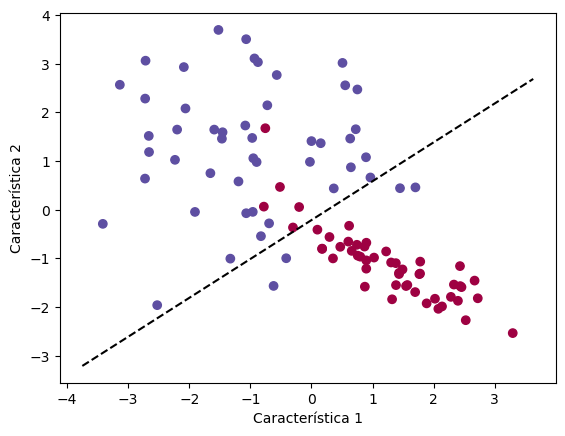

In [21]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
x_min, x_max = plt.xlim()
x_vals = np.array([x_min, x_max])
y_vals = -(weights[0] * x_vals + bias) / weights[1]
plt.plot(x_vals, y_vals, 'k--')

plt.show()

Observa en qué lugar está la actualización de pesos. Se hace una vez para todos los ejemplos del ejercicio. A esto le llamamos descenso de gradiente por lotes. (Lo vuelve más estable, resistente al ruido)

Tiene las ventajas de ser más estable y resistente a ruido. A costa de utilizar más memoria, y tener un mayor tiempo por iteración. Muchas veces converge mas lentamente.

Existen otras aproximaciones como

- Descenso de Gradiente Estocástico (SGD): Se selecciona un solo ejemplo de entrenamiento al azar (estocásticamente) en cada iteración y con este solo ejemplo actualizan los pesos.
- Descenso de gradiente en mini-lotes Es intermedio entre DG en lotes y SDG, donde no se toman todos los elementos de entrenamiento sino pequeños lotes. Muy útil cuando no se puede cargar totalmente en memoria. Resulta en un parámetro más para ajustar.

**Discusión**
¿Cuáles son las ventajas de uno y otro?
Librerías como TensorFlow ofrece una gran variedad de algoritmos a los cuales llama optimizadores:

- [SGD](https://keras.io/api/optimizers/sgd/): Descenso de gradiente con momento.
- [RMSprop](https://keras.io/api/optimizers/rmsprop/): Utiliza medias móviles del gradiente para ajustar la tasa de aprendizaje.
- [Adam](https://keras.io/api/optimizers/adam/): Descenso de gradiente estocástico que adapta la tasa de aprendizaje con los momentos estadísticos.
- [AdamW](https://keras.io/api/optimizers/adamw/):
- [Adadelta](https://keras.io/api/optimizers/adadelta/): Basado en Adam usa una tasa de aprendizaje para cada dimensión respecto a la frecuencia de actualización en una ventana.
- [Adagrad](https://keras.io/api/optimizers/adagrad/): Basado en Adam usa una tasa de aprendizaje para cada dimensión respecto a la frecuencia de actualización en el entrenamiento.
- [Adamax](https://keras.io/api/optimizers/adamax/): Tiene la capacidad de adaptar tasa de aprendizaje basado en las características de los datos. Por ejemplo, datos de habla con ruido variable.
- [Adafactor](https://keras.io/api/optimizers/adafactor/): Solo guarda información parcial de los gradientes pasados.
- [Nadam](https://keras.io/api/optimizers/Nadam/): Adam con momento de Nesterov.
- [Ftrl](https://keras.io/api/optimizers/ftrl/): Adaptado para modelos espacios de características muy grandes.


Como puedes observar casi todos los métodos se basan en descenso de gradiente. Y muchos de ellos utilizan momento. En particular, los sistemas con momento cambian regla de actualización de los pesos por:

$$ v = m * v - \alpha \nabla_w L$$
$$ w = w + v $$

Donde $m$ es una constante mayor a 0

**Discusión**:
¿En qué puede ayudar el momento?


## Otras implementaciones

En el siguiente ejemplo veremos cómo podemos utilizar TensorFlow/Keras para entrenar una neurona, ahora quedan mucho más claros los parámetros que vamos a utilizar.


Comenzamos generando datos para clasificación, definimos el modelo y finalmente hacemos el entrenamiento.



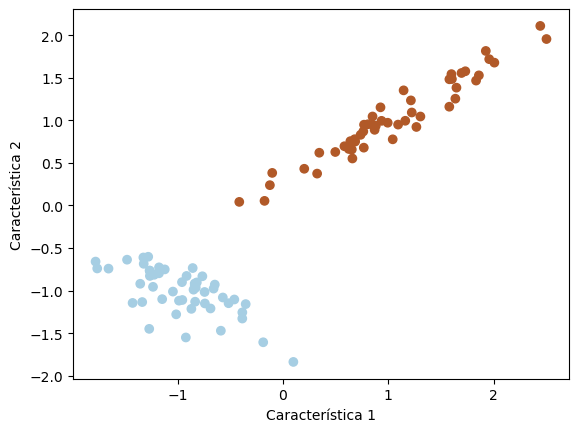

In [22]:
# Generar datos
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

# Graficar los datos
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

In [24]:

modelo = tf.keras.models.Sequential()
#Units numero de neuronas 
#input dos entradas 
# Dense todas las neuronas se conectan con todas
modelo.add(tf.keras.layers.Dense(units=1, activation='sigmoid', input_shape=(2,)))

# Como vamos a entrenar neurona
modelo.compile(optimizer='SGD', loss='mean_squared_error',metrics=['accuracy'])

In [25]:
# callback funcion invocada cada que termina un epoch
modelo.fit(
    X,
    y,
    epochs=1000,
    verbose=0,
#    batch_size=20,
    callbacks=[TqdmCallback(verbose=0)]
    )

0epoch [00:00, ?epoch/s]

313/313 [==============================] - 1s 2ms/step


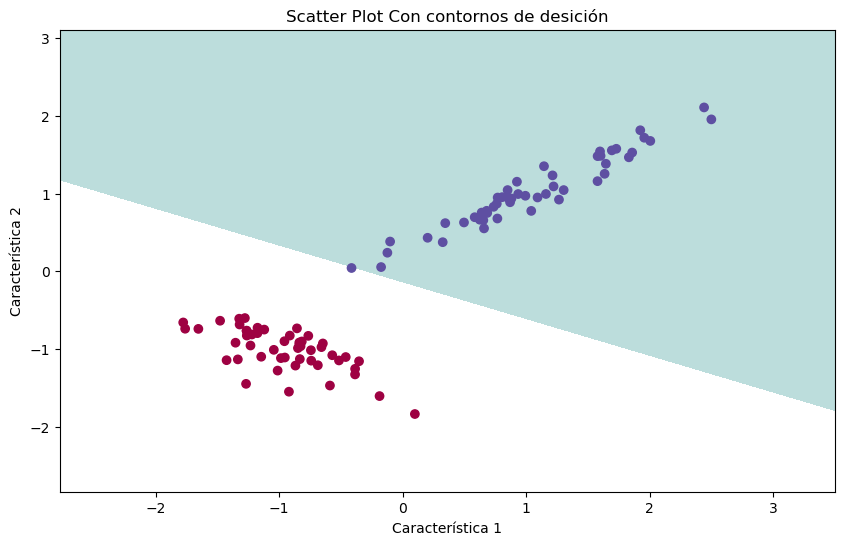

In [26]:
plt.figure(figsize=(10, 6))
xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                     np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))
Z = modelo.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, levels= [0.5,1000])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, marker='o')
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.title("Scatter Plot Con contornos de desición")
plt.show()

**Ejercicio**

Obtén la tabla de confusión e interprétala
Tarea!!!

---

## Funciones de pérdida

Así como los optimizadores, tenemos una serie de [funciones de perdida]( https://keras.io/api/losses/) que se adaptan a diferentes problemas.

**Regresión:**

- [Error Cuadrático Medio](https://keras.io/api/losses/regression_losses/#meansquarederror-class) (MSE): Calcula el promedio de los cuadrados de las diferencias entre las predicciones y los valores reales.
- [Error Absoluto Medio](https://keras.io/api/losses/regression_losses/#meanabsoluteerror-class) (MAE): Calcula el promedio de las diferencias absolutas entre las predicciones y los valores reales.
- [Error Huber](https://keras.io/api/losses/regression_losses/#huber-class): Combina las propiedades de MSE y MAE.

**Clasificación**

- [Entropía Cruzada Binaria](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class) (Binary Cross-Entropy): Es utilizada para medir la discrepancia entre las probabilidades predichas y las etiquetas verdaderas.
- [Entropía Cruzada Categórica](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) (Categorical Cross-Entropy): Extensión de la entropía cruzada para clasificación multiclase.
- [Hinge Loss](https://keras.io/api/losses/hinge_losses/#hinge-class) : Utilizada en máquinas de soporte vectorial (SVM) para problemas de clasificación binaria. Es especialmente útil cuando se desea maximizar el margen entre las clases.



In [ ]:
#np.linalg.lstsq(X_bias, y, rcond=None)[0]